<a href="https://www.kaggle.com/code/marinabalakina/dll30-dz5-ipynb?scriptVersionId=156164797" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Домашнее задание к занятию «Улучшение качества обучения нейросети»
**Цель задания:**
научиться использовать в коде различные методы Transfer Learning.

**Задание:**
На примере датасета персонажей мультфильма Симпсонов:
1. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
2. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
3. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
4. Оформите вывод по результатам проведённых экспериментов.

**Формат сдачи работы**

Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите - зачёт/незачёт.

**Задание считается выполненным, если:**

* LR Schedulers применяются корректно, проведено 2 эксперимента
* при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась
* корректно проведено обучение и дообучение любой сети (VGG, EfficientNet или MobileNet), получены сравнимые результаты или лучше по сравнению с практикой на занятии
* итоговый вывод содержит подробный корректный анализ проведённых экспериментов

**Задание будет отправлено на доработку, если:**

* при встраивании LR шедулеров возникли ошибки/проведено < 2 экспериментов
* не удалось подобрать аугментации, сильно снижающие качество изображений/был выбран совсем тривиальный пример
* не проведены эксперименты с новой архитектурой сети
* вывод не написан/не подробный/содержит фактические ошибки

# Импорт библиотек и пользовательские функции

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import mobilenet_v2
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau, StepLR

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='white')


In [3]:
def check_folder(name):
    folder_contents = os.listdir(name)
    if len(folder_contents) > 0:
        return True
    else:
        return False

In [4]:
# Возможность работы на графическом ускорителе
device = "cuda" if torch.cuda.is_available() else "cpu"
#Размер картинок для resize
input_size = 224
# Размера батча, к-во эпох
batch_size = 64
num_epochs = 10
learning_rate = 0.1
print(device)

cuda


In [5]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

In [6]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [7]:
data_dir = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*")

In [8]:
len(data_image_paths)

42

In [9]:
def prepare_datasets(data_dir, train_augmentations=None, val_augmentations=None):
    """аугментация данных происходит в соотвествии с пайплайнами аугментации train_augmentations и val_augmentations"""
    data_paths = glob.glob(f"{data_dir}/*")
    data_image_paths = []
    data_image_labels = []
    for name in data_paths:
        if check_folder(name):
            data_image_paths += glob.glob(f"{name}/*.jpg")
        else:
            print(name)
            os.rmdir(name)
    data_image_labels = [path.split('/')[-2] for path in data_image_paths]
    print(len(data_image_paths), len(data_image_labels))
    train_files_path, val_files_path = train_test_split(
        data_image_paths,
        test_size=0.3,
        stratify=data_image_labels
    )

    print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")
    input_size = 224
    if train_augmentations is not None:
        train_transform = transforms.Compose(train_augmentations)
    else:
        train_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])
    if val_augmentations is not None:
        val_transform = transforms.Compose(val_augmentations)
    else:
        val_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])

    train_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=train_transform,
          is_valid_file=lambda x: x in train_files_path
      )

    val_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=val_transform,
          is_valid_file=lambda x: x in val_files_path
      )
    return train_dataset, val_dataset

In [10]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    schedulers=None, names=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''
    times = []
    l_rates = []
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()
        epoch_time = time.time() - start_time
        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, epoch_time))
        times.append(epoch_time)
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

        # подключаем шедулер
        if schedulers is not None:
            for scheduler, name in zip(schedulers, names): 
                if name == 'ReduceLROnPlateau':
                    scheduler.step(val_loss)
                else:
                    scheduler.step()
                    l_rates.append(scheduler.get_last_lr())
        else:
            l_rates.append(learning_rate)
    return model, history, times, l_rates

In [11]:
def fine_tuning(schedulers, name):
    fine_tuning_model = nn.Sequential()

    fine_tuning_model.add_module('resnet', torchvision.models.resnet18(pretrained=True))

    # добавим новые слои для классификации для нашей конкретной задачи
    fine_tuning_model.add_module('relu_1', nn.ReLU())
    fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
    fine_tuning_model.add_module('relu_2', nn.ReLU())
    fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

    fine_tuning_model = fine_tuning_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

    clf_model, history, times = train(
      fine_tuning_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, name
    )
    return clf_model, history, times

# 1. Загрузка данных

Все данные теперь находятся в папке data.
Структура трейн данных (simpsons_dataset/) следующая:


-- class_name_0
---- img_0
---- img_1
---- ...
---- img_n
...
-- class_name_k
---- img_0
---- img_1
---- ...
---- img_m

Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

## 1.1. Подготовка вариантов аугментаций

In [12]:
# Подготовим 3 варианта пайплайнов аугментации для train и val
train_augmentations  = []
val_augmentations = []

# 'Base' - Набор аугментаций, исполоьзованных на занятии для train
train_augmentations_base = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ToTensor(),
  ]
# 'Good' - Предполагаемый набор аугментаций для train для улучшения качества модели
train_augmentations_good = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
  ]
# 'Bad' - Предполагаемый набор аугментаций для train для ухудшенния качества модели
train_augmentations_bad = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ElasticTransform(alpha=250.0),
      transforms.ToTensor(),
  ]
train_augmentations.append(('Base', train_augmentations_base))
train_augmentations.append(('Good', train_augmentations_good))
train_augmentations.append(('Bad', train_augmentations_bad))

# 'Base' - Набор аугментаций, исполоьзованных на занятии для val
val_augmentations_base = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
# 'Good' - Предполагаемый набор аугментаций для val для улучшения качества модели
val_augmentations_good = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
# 'Bad' - Предполагаемый набор аугментаций для val для ухудшения качества модели
val_augmentations_bad = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
val_augmentations.append(('Base', val_augmentations_base))
val_augmentations.append(('Good', val_augmentations_good))
val_augmentations.append(('Bad', val_augmentations_bad))

## 1.2. Подготовка датасетов с минимально необходимыми аугментациями в пайплайне

In [13]:
# Подготовка датасетов с минимально необходимым набором аугментаций
train_dataset, val_dataset = prepare_datasets(data_dir)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


In [14]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из val и train

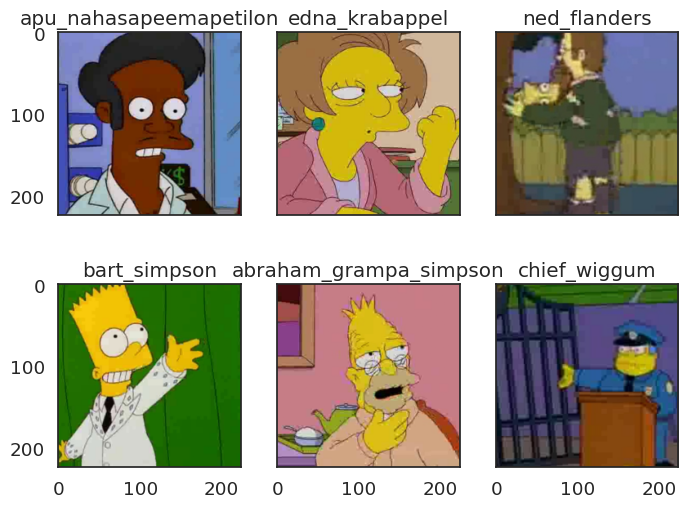

In [16]:
show_images(val_dataset)

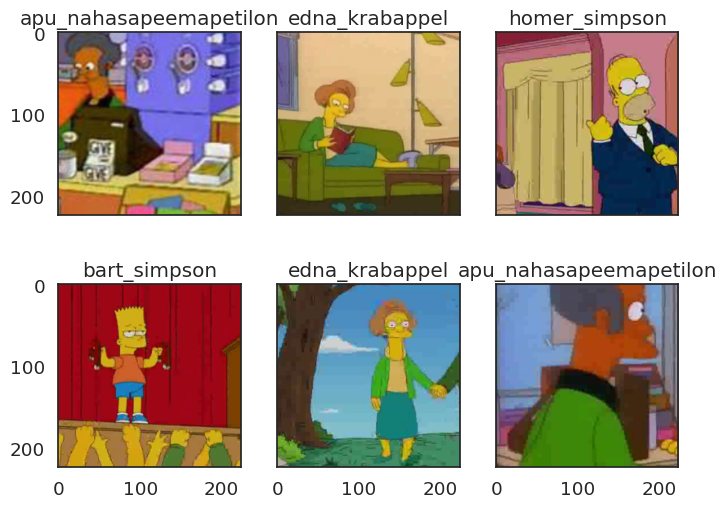

In [17]:
show_images(train_dataset)


Невооруженным взглядом видно, что картинки из `train` принципиально не отличаются от картинок из `val`, т.к. ко всем картинками применялись только операции Resize() И ToTensor()

**Создадим DataLoader-ы и функции для обучения**

In [130]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 2. Обучение моделей

In [19]:
df_results = pd.DataFrame(columns=['model','augmentation', 'sheduler','time', 'lr', 'epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

## 2.1. Минимально необходимая аугментация

### 2.1.1 Обучение `ResNet18` с нуля

2.1.1 Обучение ResNet18 с нуля

In [20]:
results = dict()

#### 2.1.1.1. learning_rate = const

Epoch 10 of 10 took 117.733s
  training loss (in-iteration): 	0.628781
  validation loss (in-iteration): 	0.866036
  training accuracy: 			83.98 %
  validation accuracy: 			77.49 %


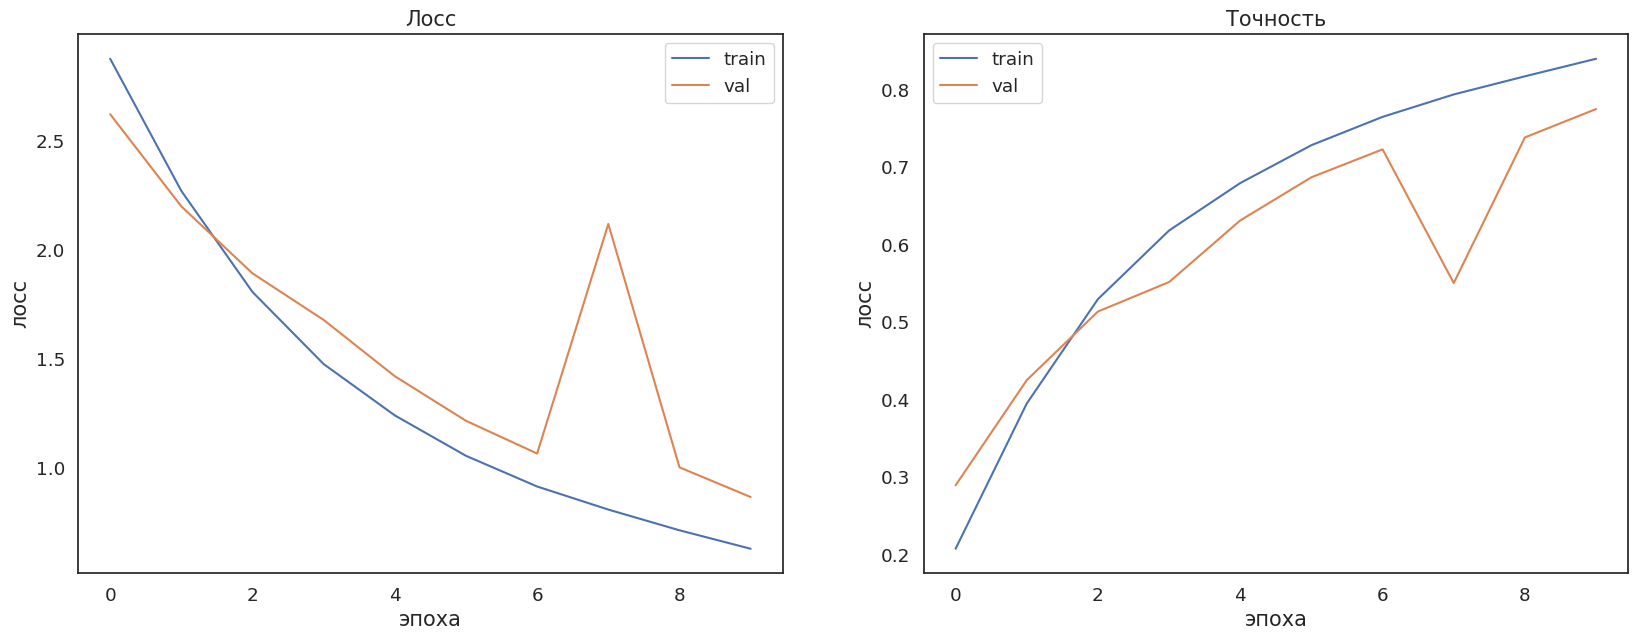

In [21]:
# lr=0.01
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None
  )
results['None'] = history

Модель не доучилась, есть потенциал роста. Увеличим шаг до 0.1

In [22]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]

Epoch 10 of 10 took 117.722s
  training loss (in-iteration): 	0.070089
  validation loss (in-iteration): 	0.489463
  training accuracy: 			98.38 %
  validation accuracy: 			87.85 %


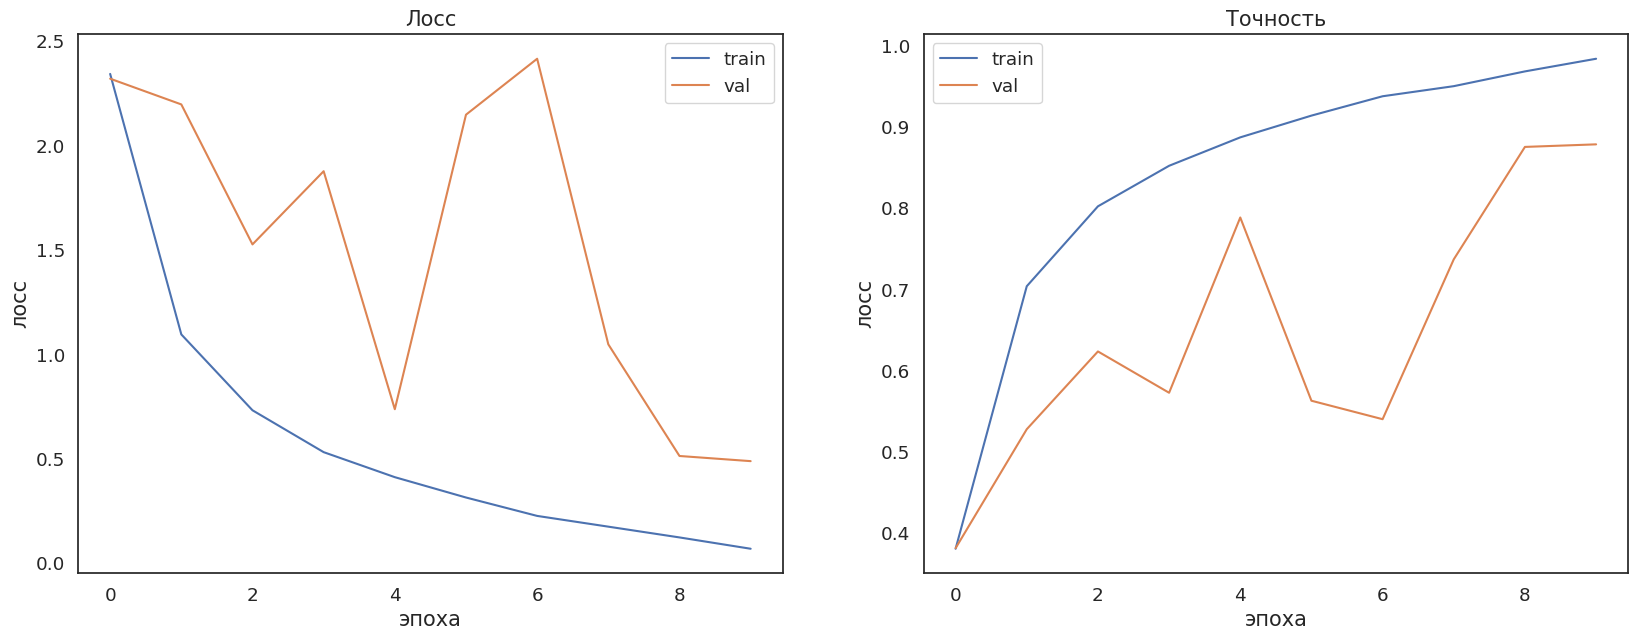

In [23]:
lr=0.1
name='None_0.1'
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

Гипотеза: При обучении модели с нуля со скоростью 0.1 по кривой обучения для train можно заметить, что за 10 эпох модуль недообучена, потенциал роста Accuracy и снижения loss далеко не исчертпан.Вполне вероятно, что при увеличении числа эпох accuracy на val может опять вырастм, как это произошло в 4 и 7 эпохах. Однако такие резкие колебания свидетельствуют о том, что была выбрана слишком большая скорость обучения. Это было сделано намеренно, чтобы в дальнейшем при использовании различных schedulers можно было бы получить выигрыш в accuracy. При первоначальном варианте - скорости 0, 01, как это было в примере на лекции, модель за указанное кол-во эпох просто не успеет обучиться до приемлемого уровня качества,поэтому прменение schedulers было бы нецелесообразно  Думаю, что эксперименты с различными schedulers это подтвердят.

In [24]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [25]:
df_results

model augmentation  sheduler        time   lr  epoch  train_loss  \
0   с нуля         Base      None  275.132039  0.1      0    2.876372   
1   с нуля         Base      None  117.456237  0.1      1    2.270191   
2   с нуля         Base      None  118.372202  0.1      2    1.806648   
3   с нуля         Base      None  116.462921  0.1      3    1.475974   
4   с нуля         Base      None  115.066713  0.1      4    1.240439   
5   с нуля         Base      None  117.316246  0.1      5    1.055114   
6   с нуля         Base      None  115.805027  0.1      6    0.914311   
7   с нуля         Base      None  119.738639  0.1      7    0.808501   
8   с нуля         Base      None  118.330251  0.1      8    0.713417   
9   с нуля         Base      None  117.733030  0.1      9    0.628781   
10  с нуля         Base  None_0.1  123.013036  0.1      0    2.343090   
11  с нуля         Base  None_0.1  118.793258  0.1      1    1.096055   
12  с нуля         Base  None_0.1  118.497819  0.1      2    0.732931   
13  с нуля         Base  None_0.1  117.942255  0.1      3    0.532478   
14  с нуля         Base  None_0.1  117.649921  0.1      4    0.412727   
15  с нуля         Base  None_0.1  119.077987  0.1      5    0.315376   
16  с нуля         Base  None_0.1  119.176414  0.1      6    0.227286   
17  с нуля         Base  None_0.1  117.379654  0.1      7    0.175839   
18  с нуля         Base  None_0.1  118.784267  0.1      8    0.124293   
19  с нуля         Base  None_0.1  117.722238  0.1      9    0.070089   

    train_accuracy  val_loss  val_accuracy  
0         0.207412  2.621986      0.289299  
1         0.394891  2.199438      0.425032  
2         0.529577  1.891972      0.513573  
3         0.618165  1.678324      0.551610  
4         0.679408  1.420164      0.631155  
5         0.728297  1.215688      0.686869  
6         0.764831  1.065588      0.722854  
7         0.793771  2.118719      0.550347  
8         0.817178  1.002152      0.738321  
9         0.839834  0.866036      0.774937  
10        0.381060  2.320182      0.381787  
11        0.703958  2.196994      0.528093  
12        0.802238  1.526949      0.623737  
13        0.852102  1.877312      0.572917  
14        0.887064  0.737995      0.788510  
15        0.913820  2.147790      0.563131  
16        0.937620  2.415617      0.540404  
17        0.950038  1.048560      0.737058  
18        0.968197  0.514135      0.875316  
19        0.983758  0.489463      0.878472

In [27]:
df_results.to_csv('none.csv', index=False)

#### 2.1.1.2. Learning Rate Scheduler = 'Multistep'

Epoch 10 of 10 took 119.499s
  training loss (in-iteration): 	0.522100
  validation loss (in-iteration): 	0.676806
  training accuracy: 			86.89 %
  validation accuracy: 			82.13 %


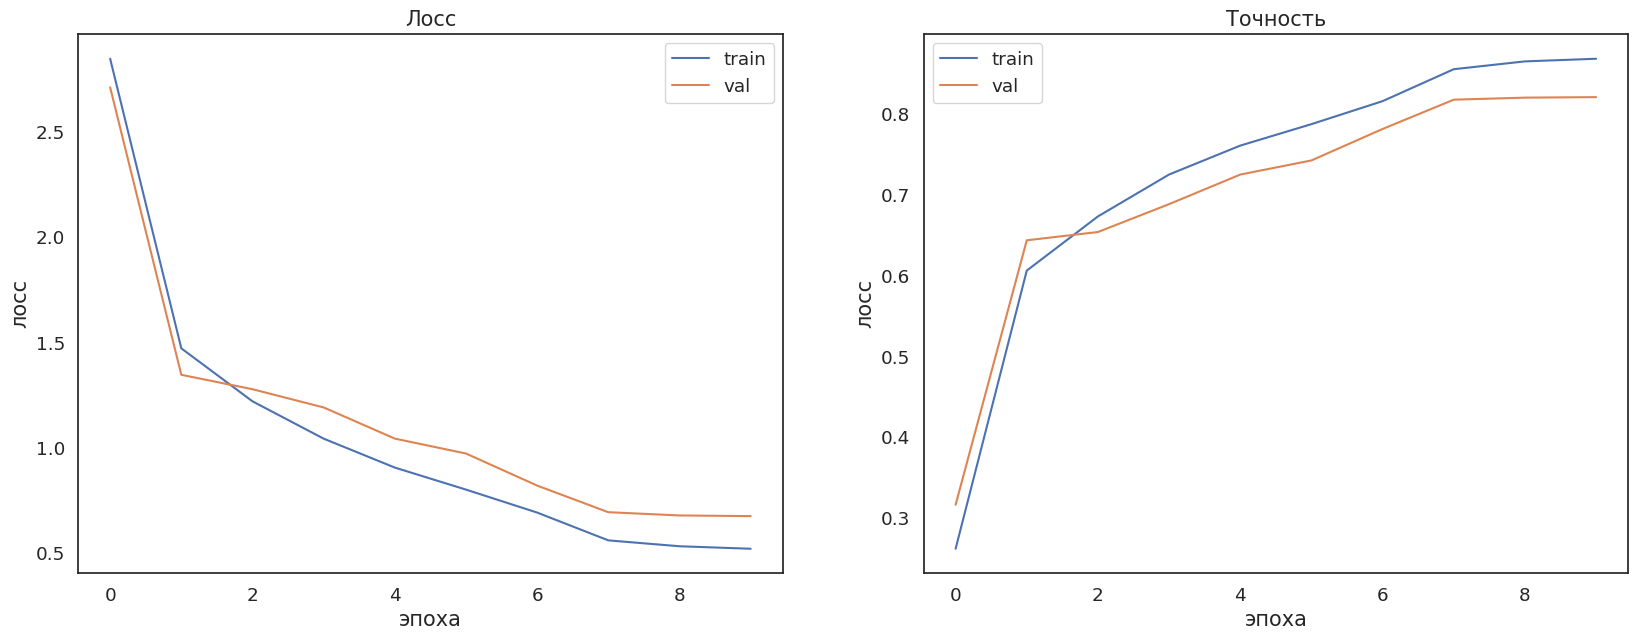

In [29]:
name = 'MultiStep'
names = ['MultiStep']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [30]:
l_rates

[[0.020000000000000004],
 [0.020000000000000004],
 [0.020000000000000004],
 [0.020000000000000004],
 [0.020000000000000004],
 [0.020000000000000004],
 [0.0020000000000000005],
 [0.0020000000000000005],
 [0.0020000000000000005],
 [0.0020000000000000005]]

In [31]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [32]:
df_results

model augmentation   sheduler        time                       lr  \
0   с нуля         Base       None  275.132039                      0.1   
1   с нуля         Base       None  117.456237                      0.1   
2   с нуля         Base       None  118.372202                      0.1   
3   с нуля         Base       None  116.462921                      0.1   
4   с нуля         Base       None  115.066713                      0.1   
5   с нуля         Base       None  117.316246                      0.1   
6   с нуля         Base       None  115.805027                      0.1   
7   с нуля         Base       None  119.738639                      0.1   
8   с нуля         Base       None  118.330251                      0.1   
9   с нуля         Base       None  117.733030                      0.1   
10  с нуля         Base   None_0.1  123.013036                      0.1   
11  с нуля         Base   None_0.1  118.793258                      0.1   
12  с нуля         Base   None_0.1  118.497819                      0.1   
13  с нуля         Base   None_0.1  117.942255                      0.1   
14  с нуля         Base   None_0.1  117.649921                      0.1   
15  с нуля         Base   None_0.1  119.077987                      0.1   
16  с нуля         Base   None_0.1  119.176414                      0.1   
17  с нуля         Base   None_0.1  117.379654                      0.1   
18  с нуля         Base   None_0.1  118.784267                      0.1   
19  с нуля         Base   None_0.1  117.722238                      0.1   
20  с нуля         Base  MultiStep  120.108202   [0.020000000000000004]   
21  с нуля         Base  MultiStep  120.229230   [0.020000000000000004]   
22  с нуля         Base  MultiStep  125.640985   [0.020000000000000004]   
23  с нуля         Base  MultiStep  118.276056   [0.020000000000000004]   
24  с нуля         Base  MultiStep  117.872291   [0.020000000000000004]   
25  с нуля         Base  MultiStep  118.558793   [0.020000000000000004]   
26  с нуля         Base  MultiStep  117.892548  [0.0020000000000000005]   
27  с нуля         Base  MultiStep  119.083121  [0.0020000000000000005]   
28  с нуля         Base  MultiStep  118.184423  [0.0020000000000000005]   
29  с нуля         Base  MultiStep  119.498934  [0.0020000000000000005]   

    epoch  train_loss  train_accuracy  val_loss  val_accuracy  
0       0    2.876372        0.207412  2.621986      0.289299  
1       1    2.270191        0.394891  2.199438      0.425032  
2       2    1.806648        0.529577  1.891972      0.513573  
3       3    1.475974        0.618165  1.678324      0.551610  
4       4    1.240439        0.679408  1.420164      0.631155  
5       5    1.055114        0.728297  1.215688      0.686869  
6       6    0.914311        0.764831  1.065588      0.722854  
7       7    0.808501        0.793771  2.118719      0.550347  
8       8    0.713417        0.817178  1.002152      0.738321  
9       9    0.628781        0.839834  0.866036      0.774937  
10      0    2.343090        0.381060  2.320182      0.381787  
11      1    1.096055        0.703958  2.196994      0.528093  
12      2    0.732931        0.802238  1.526949      0.623737  
13      3    0.532478        0.852102  1.877312      0.572917  
14      4    0.412727        0.887064  0.737995      0.788510  
15      5    0.315376        0.913820  2.147790      0.563131  
16      6    0.227286        0.937620  2.415617      0.540404  
17      7    0.175839        0.950038  1.048560      0.737058  
18      8    0.124293        0.968197  0.514135      0.875316  
19      9    0.070089        0.983758  0.489463      0.878472  
20      0    2.845249        0.261745  2.709578      0.316288  
21      1    1.472183        0.606425  1.346826      0.643939  
22      2    1.221132        0.673517  1.278455      0.654198  
23      3    1.044112        0.725465  1.192070      0.688763  
24      4    0.906945        0.761273  1.044313      0.725379  
25      5    0.

Качество модели выросло - с 77,49 % на тесте при lr= 0.01 до 82,13% на тесте  при использовании Multistep, lr=0.02 до 7 эпохи и 0.002 в 7-10 эпохах. Вполне вероятно, что если после 10 эпохи попробовать еще один шедулер - ReduceLROnPlateau , то можно будет дополнительно повысить качество модели. Попробую 2 варианта: 1 -Последовательное применение двух шедулеров в каждой эпохе и 2 - применение сначала Multistep В течение 10 эпох, а затем - ReduceLROnPlateau в течение еще 10 эпох

In [33]:
df_results.to_csv('multistep.csv', index=False)

#### 2.1.1.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau', вариант 2 

Epoch 10 of 10 took 119.656s
  training loss (in-iteration): 	0.455412
  validation loss (in-iteration): 	0.617108
  training accuracy: 			88.67 %
  validation accuracy: 			83.19 %


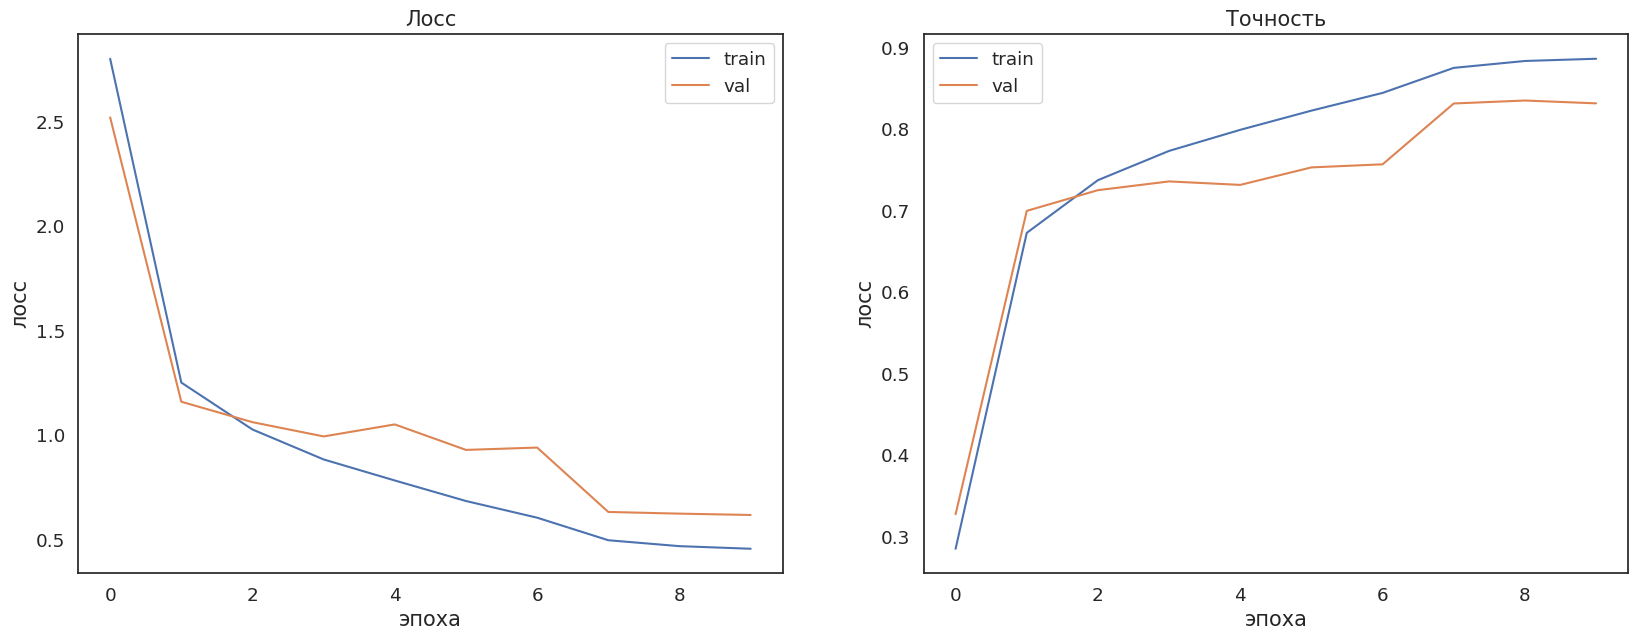

In [34]:
name = 'Combo2'
names = ['MultiStep']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history


In [35]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [36]:
df_results.to_csv('combo2.csv', index=False)

Epoch 7 of 7 took 192.916s
  training loss (in-iteration): 	0.391488
  validation loss (in-iteration): 	0.590717
  training accuracy: 			90.42 %
  validation accuracy: 			84.47 %


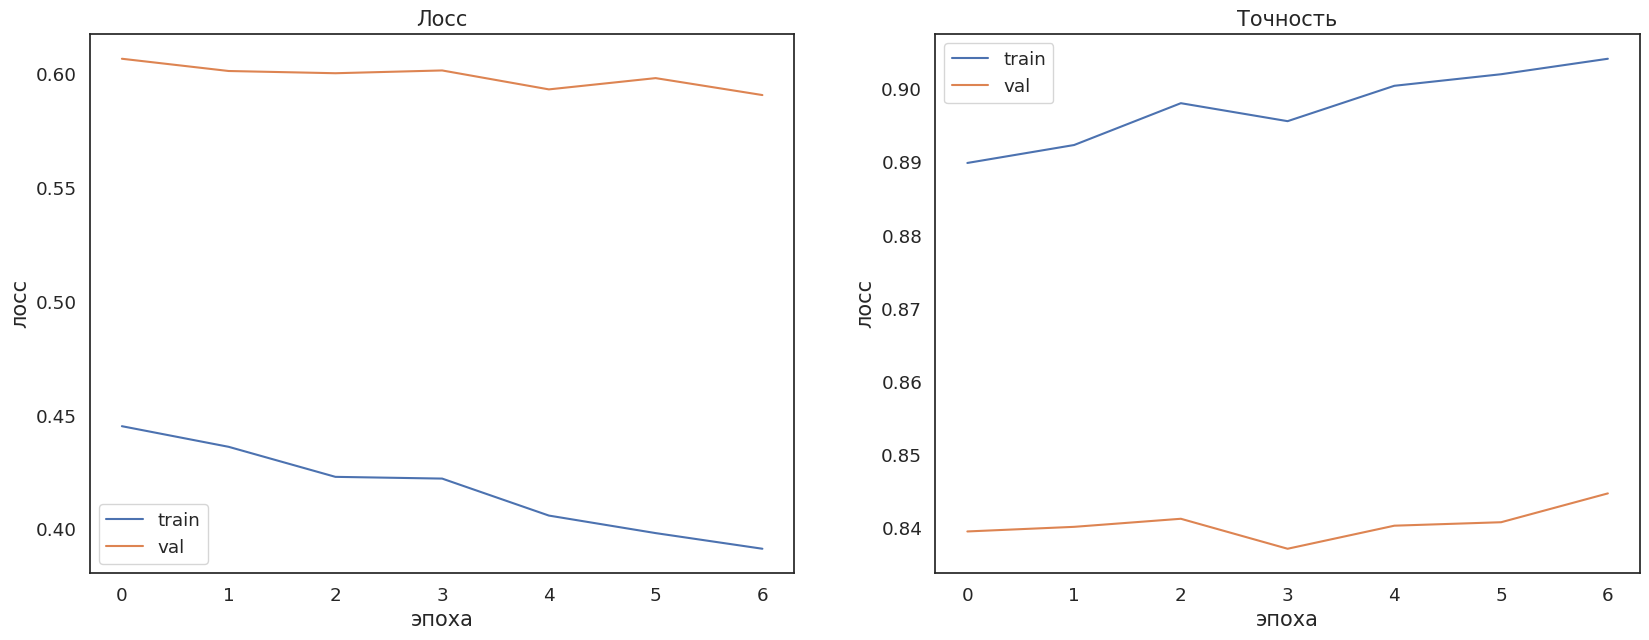

In [37]:
names = ['ReduceLROnPlateau']
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers = []
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      7, schedulers, names
  )
results[name] = history

In [43]:
results[name]

defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {'loss': defaultdict(list,
                         {'train': [0.4453076256935253,
                           0.43624814180047233,
                           0.42306059410218066,
                           0.4222994465624922,
                           0.4060545796325113,
                           0.39836012913670604,
                           0.3914876588046811],
                          'val': [0.6066616773605347,
                           0.6012800654227083,
                           0.6003040870783305,
                           0.6015248012663138,
                           0.5932095461722576,
                           0.5981566723850038,
                           0.5907167644061223]}),
             'acc': defaultdict(list,
                         {'train': [0.8899225517216695,
                           0.8923788835993987,
                           0.8981036133581501,
                           0.8956

In [44]:
for i in range(7):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], 0.002, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [45]:
df_results

model augmentation   sheduler        time                       lr  \
0   с нуля         Base       None  275.132039                      0.1   
1   с нуля         Base       None  117.456237                      0.1   
2   с нуля         Base       None  118.372202                      0.1   
3   с нуля         Base       None  116.462921                      0.1   
4   с нуля         Base       None  115.066713                      0.1   
5   с нуля         Base       None  117.316246                      0.1   
6   с нуля         Base       None  115.805027                      0.1   
7   с нуля         Base       None  119.738639                      0.1   
8   с нуля         Base       None  118.330251                      0.1   
9   с нуля         Base       None  117.733030                      0.1   
10  с нуля         Base   None_0.1  123.013036                      0.1   
11  с нуля         Base   None_0.1  118.793258                      0.1   
12  с нуля         Base   None_0.1  118.497819                      0.1   
13  с нуля         Base   None_0.1  117.942255                      0.1   
14  с нуля         Base   None_0.1  117.649921                      0.1   
15  с нуля         Base   None_0.1  119.077987                      0.1   
16  с нуля         Base   None_0.1  119.176414                      0.1   
17  с нуля         Base   None_0.1  117.379654                      0.1   
18  с нуля         Base   None_0.1  118.784267                      0.1   
19  с нуля         Base   None_0.1  117.722238                      0.1   
20  с нуля         Base  MultiStep  120.108202   [0.020000000000000004]   
21  с нуля         Base  MultiStep  120.229230   [0.020000000000000004]   
22  с нуля         Base  MultiStep  125.640985   [0.020000000000000004]   
23  с нуля         Base  MultiStep  118.276056   [0.020000000000000004]   
24  с нуля         Base  MultiStep  117.872291   [0.020000000000000004]   
25  с нуля         Base  MultiStep  118.558793   [0.020000000000000004]   
26  с нуля         Base  MultiStep  117.892548  [0.0020000000000000005]   
27  с нуля         Base  MultiStep  119.083121  [0.0020000000000000005]   
28  с нуля         Base  MultiStep  118.184423  [0.0020000000000000005]   
29  с нуля         Base  MultiStep  119.498934  [0.0020000000000000005]   
30  с нуля         Base     Combo2  119.948835   [0.020000000000000004]   
31  с нуля         Base     Combo2  121.132148   [0.020000000000000004]   
32  с нуля         Base     Combo2  118.397073   [0.020000000000000004]   
33  с нуля         Base     Combo2  122.367374   [0.020000000000000004]   
34  с нуля         Base     Combo2  122.292925   [0.020000000000000004]   
35  с нуля         Base     Combo2  118.026712   [0.020000000000000004]   
36  с нуля         Base     Combo2  117.991634  [0.0020000000000000005]   
37  с нуля         Base     Combo2  120.897187  [0.0020000000000000005]   
38  с нуля         Base     Combo2  119.065737  [0.0020000000000000005]   
39  с нуля         Base     Combo2  119.655917  [0.0020000000000000005]   
40  с нуля         Base     Combo2  119.540182                    0.002   
41  с нуля         Base     Combo2  118.075088                    0.002   
42  с нуля         Base     Combo2  118.190060                    0.002   
43  с нуля         Base     Combo2  122.089187                    0.002   
44  с нуля         Base     Combo2  135.271010                    0.002   
45  с нуля         Base     Combo2  190.610229                    0.002   
46  с нуля         Base     Combo2  192.915869                    0.002   

    epoch  train_loss  train_accuracy  val_loss  val_accuracy  
0       0    2.876372        0.207412  2.621986      0.289299  
1       1    2.270191        0.394891  2.199438      0.425032  
2       2    1.806648        0.529577  1.891972      0.513573  
3       3    1.475974        0.618165  1.678324      0.551610  
4       4    1.240439        0.679408  1.420164      0.631155  
5       5    1.05511

Использование двух разных шедулеров и дополнительных 7 эпох позволило поднять accuracy еще на1,5 %, но в конце 17 эпохи началось переобучеение

#### 2.1.1.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau', вариант 1

Epoch 10 of 10 took 116.542s
  training loss (in-iteration): 	0.404014
  validation loss (in-iteration): 	0.561714
  training accuracy: 			90.05 %
  validation accuracy: 			85.01 %


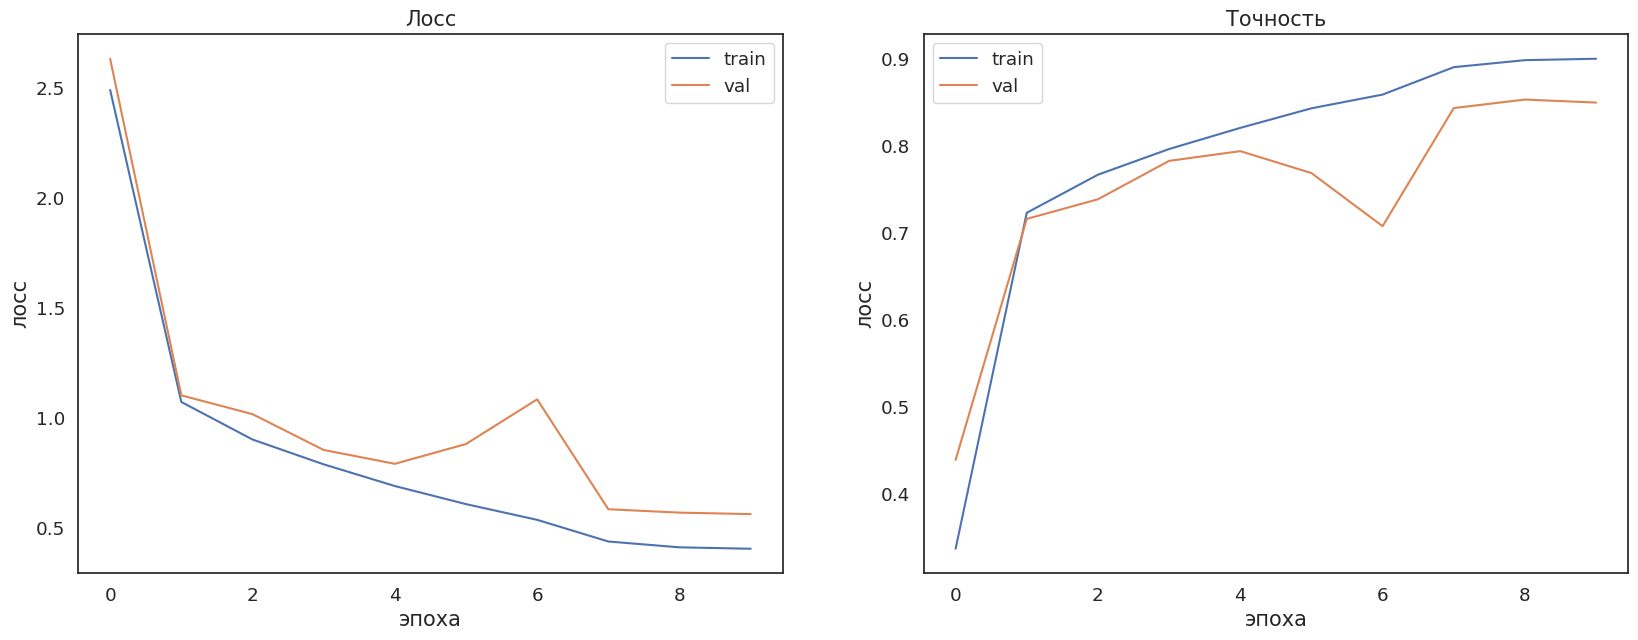

In [46]:
name = 'Combo1'
names = ['MultiStep', 'ReduceLROnPlateau']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [47]:
results[name]

defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {'loss': defaultdict(list,
                         {'train': [2.492172601441629,
                           1.0720120311824515,
                           0.9012185124330646,
                           0.7882895274453808,
                           0.6895478041151205,
                           0.6071377460352718,
                           0.5356297555448707,
                           0.43703296728529784,
                           0.4104857064751038,
                           0.4040143255583584],
                          'val': [2.6341467894086934,
                           1.102146541379919,
                           1.0166473641540066,
                           0.8537079618133679,
                           0.7905570089516013,
                           0.8807128953813302,
                           1.0839797932692248,
                           0.5838336490771987,
                           0.56840873208

In [48]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [49]:
df_results.to_csv('combo1.csv', index=False)

### 2.1.2. ResNet18 как `Feature Extractor`

#### 2.1.2.1. learning_rate = const

In [131]:
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

Epoch 10 of 10 took 102.034s
  training loss (in-iteration): 	0.651115
  validation loss (in-iteration): 	0.916781
  training accuracy: 			81.12 %
  validation accuracy: 			76.22 %


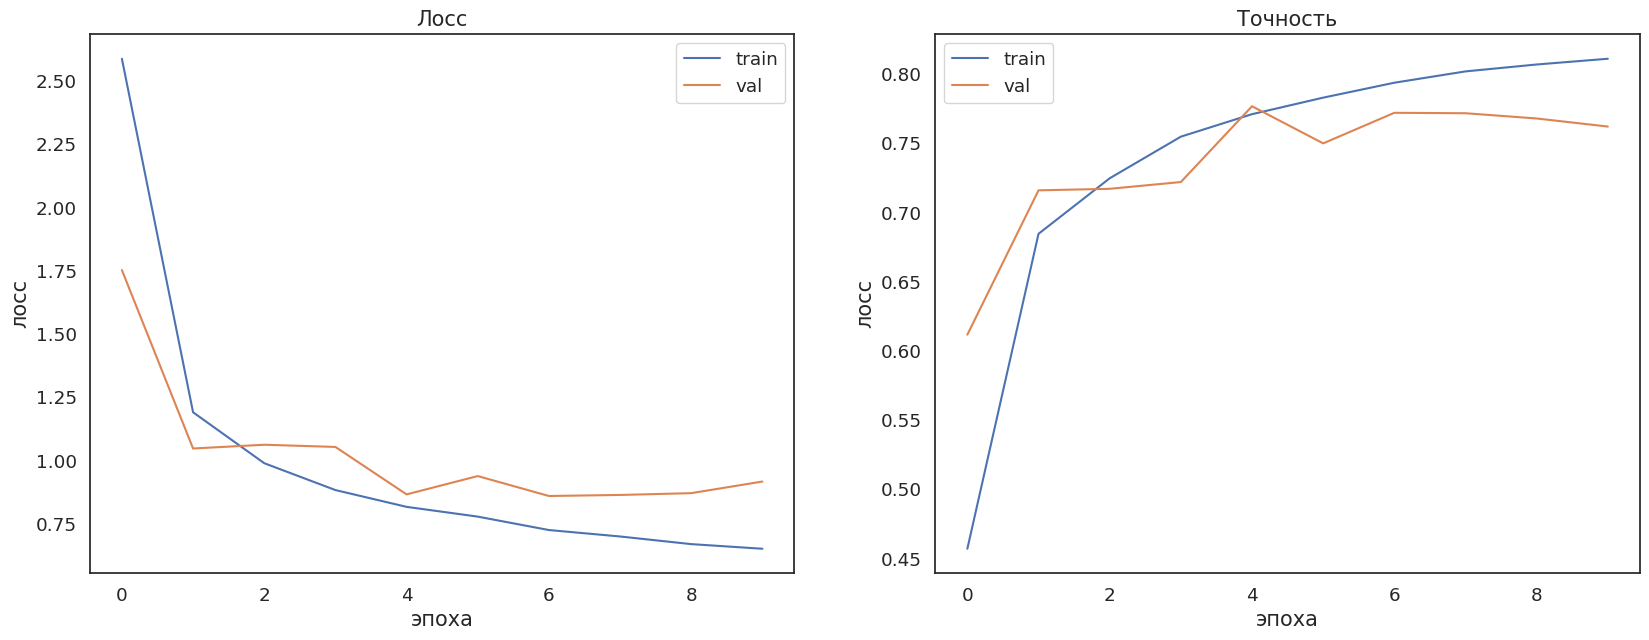

In [132]:
# возьмём предобученную сеть
name = 'None'
# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [133]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]

In [134]:
df_results.to_csv('feature_extraction.csv', index=False)

#### 2.1.2.2. Learning Rate Scheduler = 'Multistep'

Epoch 10 of 10 took 116.154s
  training loss (in-iteration): 	0.645642
  validation loss (in-iteration): 	0.876089
  training accuracy: 			81.70 %
  validation accuracy: 			76.72 %


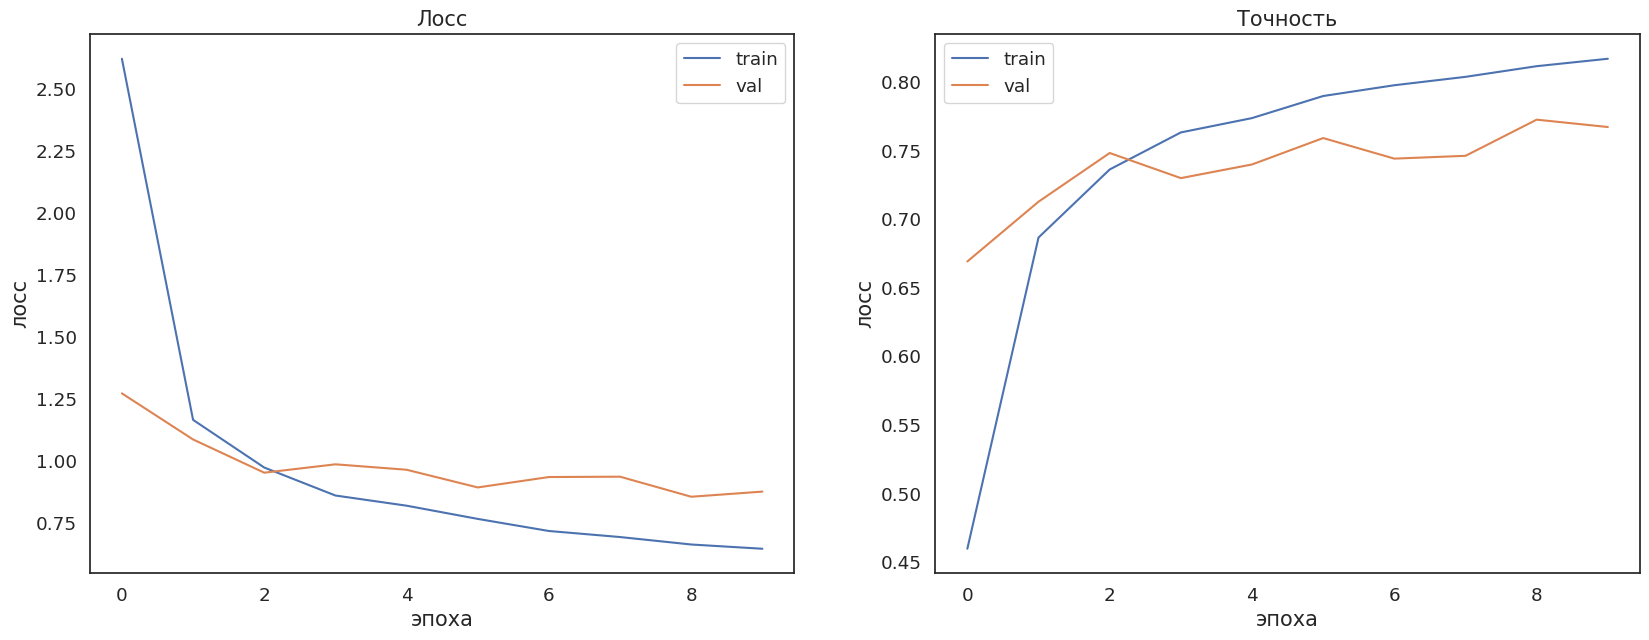

In [61]:
name = 'Multistep'
names = ['MultiStep']
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [63]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results['None']['loss']['val'][i], results[name]['acc']['val'][i]]

Переобучение начинная с 4 эпохи при выбранном шаге и использовании шедулера

In [64]:
df_results.to_csv('feature_extraction_multistep.csv', index=False)

#### 2.1.2.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau', вариант 1 

Epoch 10 of 10 took 104.853s
  training loss (in-iteration): 	0.866637
  validation loss (in-iteration): 	0.995075
  training accuracy: 			77.80 %
  validation accuracy: 			74.51 %


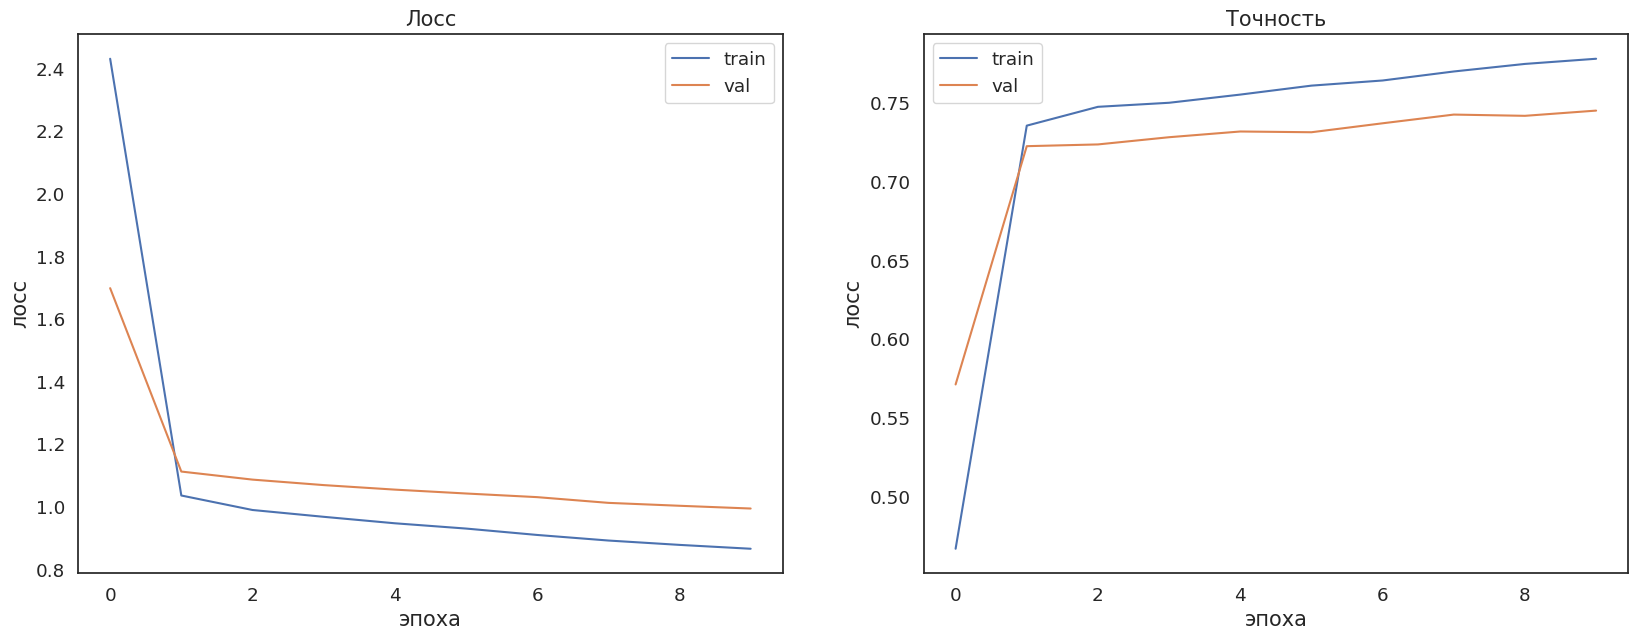

In [65]:
name = 'Combo1'
names = ['MultiStep', 'ReduceLROnPlateau']
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs,  schedulers, names
  )
results[name] = history

In [66]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [67]:
df_results

model augmentation sheduler        time  \
0              с нуля         Base     None  275.132039   
1              с нуля         Base     None  117.456237   
2              с нуля         Base     None  118.372202   
3              с нуля         Base     None  116.462921   
4              с нуля         Base     None  115.066713   
..                ...          ...      ...         ...   
92  feature_extractor         Base   Combo1  102.533588   
93  feature_extractor         Base   Combo1  102.182842   
94  feature_extractor         Base   Combo1  102.667214   
95  feature_extractor         Base   Combo1  103.375323   
96  feature_extractor         Base   Combo1  104.852544   

                         lr  epoch  train_loss  train_accuracy  val_loss  \
0                       0.1      0    2.876372        0.207412  2.621986   
1                       0.1      1    2.270191        0.394891  2.199438   
2                       0.1      2    1.806648        0.529577  1.891972   
3                       0.1      3    1.475974        0.618165  1.678324   
4                       0.1      4    1.240439        0.679408  1.420164   
..                      ...    ...         ...             ...       ...   
92  [0.0020000000000000005]      5    0.931119        0.760955  1.043075   
93  [0.0020000000000000005]      6    0.910695        0.764213  1.031430   
94  [0.0020000000000000005]      7    0.892895        0.769935  1.013169   
95  [0.0020000000000000005]      8    0.878975        0.774728  1.003873   
96  [0.0020000000000000005]      9    0.866637        0.778010  0.995075   

    val_accuracy  
0       0.289299  
1       0.425032  
2       0.513573  
3       0.551610  
4       0.631155  
..           ...  
92      0.731376  
93      0.737058  
94      0.742582  
95      0.741793  
96      0.745107  

[97 rows x 10 columns]

In [68]:
df_results.to_csv('feature_extraction_combo1.csv', index=False)

#### 2.1.2.4. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau', вариант 2 

Epoch 10 of 10 took 115.946s
  training loss (in-iteration): 	0.886961
  validation loss (in-iteration): 	1.017004
  training accuracy: 			77.00 %
  validation accuracy: 			73.74 %


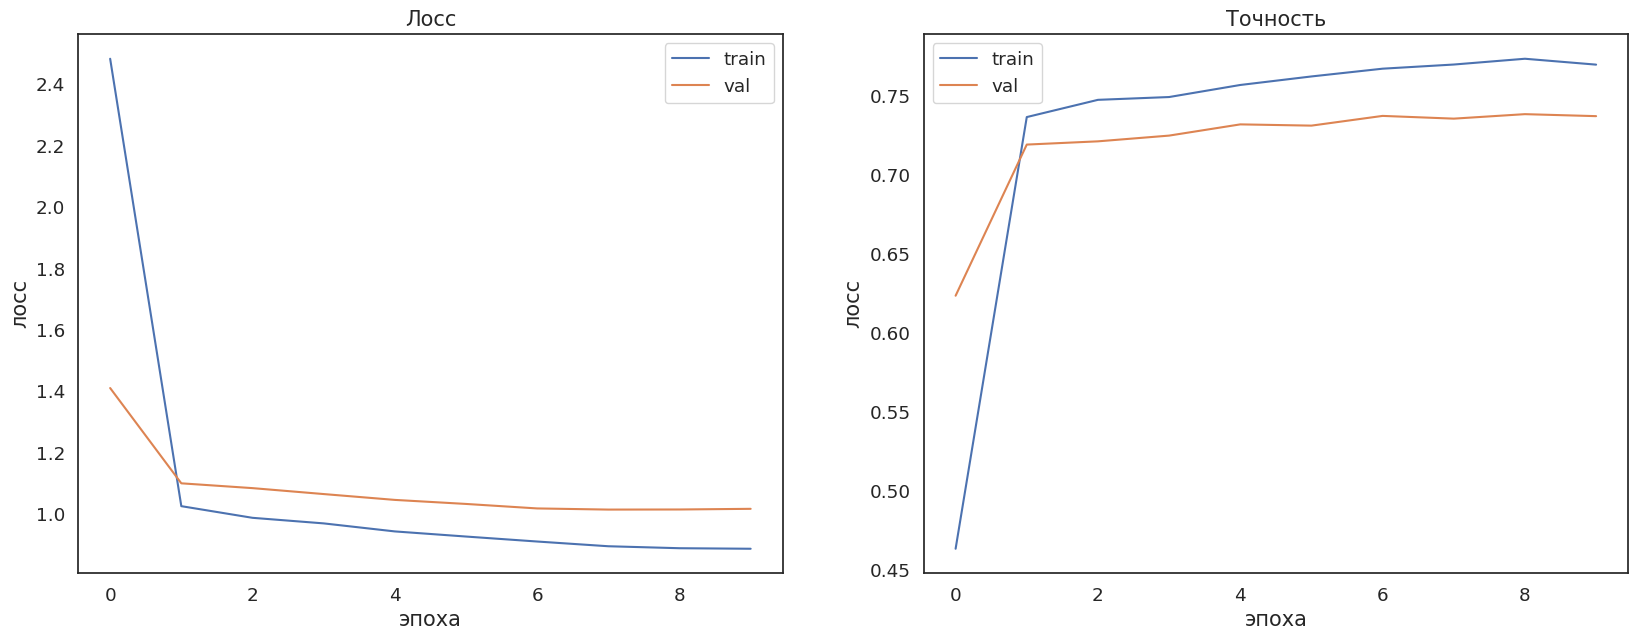

In [69]:
# сначала - 10 эпох с Multistep
name = 'Combo2'
names = ['MultiStep']
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs,  schedulers, names
  )
results[name] = history

In [70]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [71]:
df_results.to_csv('feature_extraction_combo2.csv', index=False)

Epoch 10 of 10 took 101.053s
  training loss (in-iteration): 	0.608469
  validation loss (in-iteration): 	0.926268
  training accuracy: 			82.60 %
  validation accuracy: 			74.54 %


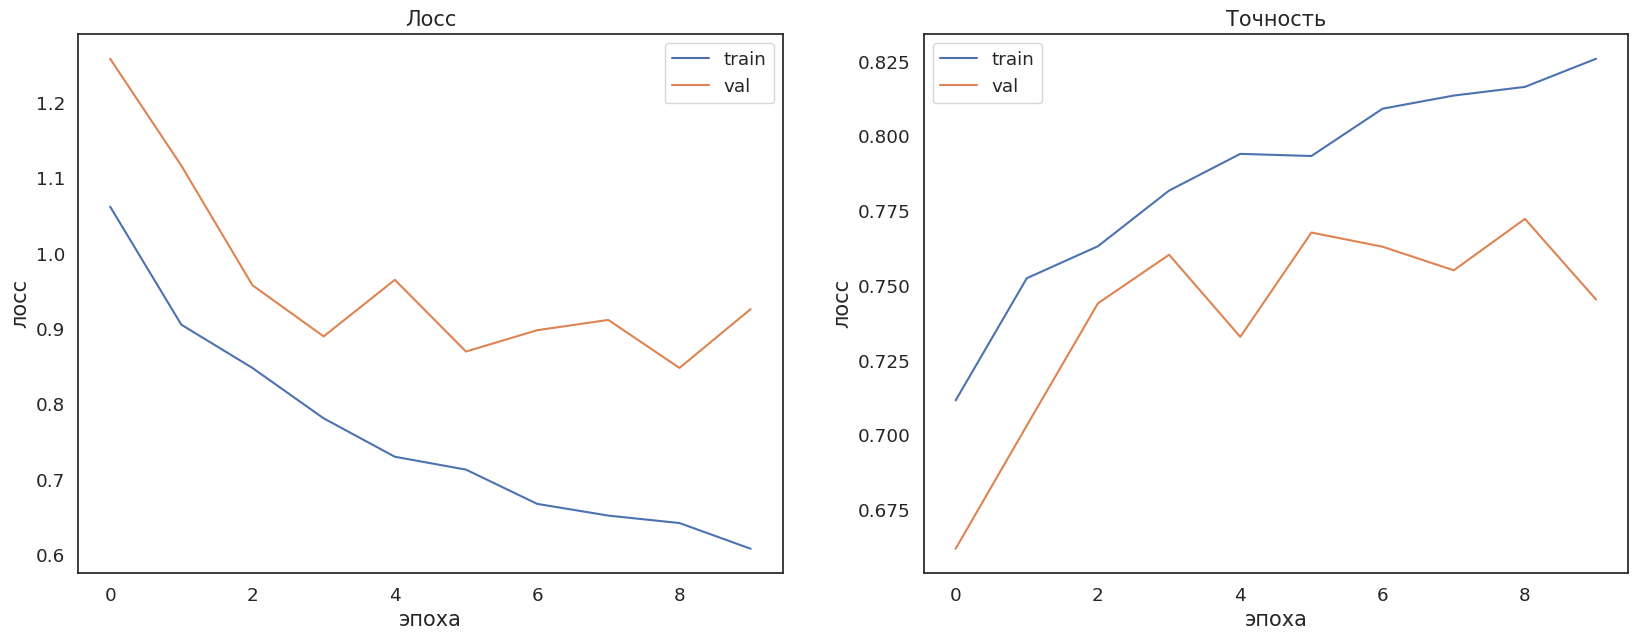

In [72]:
# И еще 7 эпох с ReduceLROnPlateau
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)
names = ['ReduceLROnPlateau']
schedulers =[]
scheduler =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs,  schedulers, names
  )
results[name] = history

In [76]:
results[name]

defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {'loss': defaultdict(list,
                         {'train': [1.0621820828800117,
                           0.9056579579953022,
                           0.8482081176932722,
                           0.7814234597974469,
                           0.7304859652009073,
                           0.7134185823811193,
                           0.6679961060592702,
                           0.6524266121689409,
                           0.6425649038959278,
                           0.6084687791146566],
                          'val': [1.258320811571497,
                           1.116594405637847,
                           0.9578752713372009,
                           0.8901157138323543,
                           0.9650997293717933,
                           0.8700140050866387,
                           0.8982814652751191,
                           0.9119426007523681,
                           0.848259968288

In [77]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [78]:
df_results.to_csv('feature_extraction_all.csv', index=False)

###2.1.3. `FineTuning`

#### 2.1.3.1. learning_rate = const

Epoch 10 of 10 took 115.186s
  training loss (in-iteration): 	0.017550
  validation loss (in-iteration): 	0.260072
  training accuracy: 			99.88 %
  validation accuracy: 			94.14 %


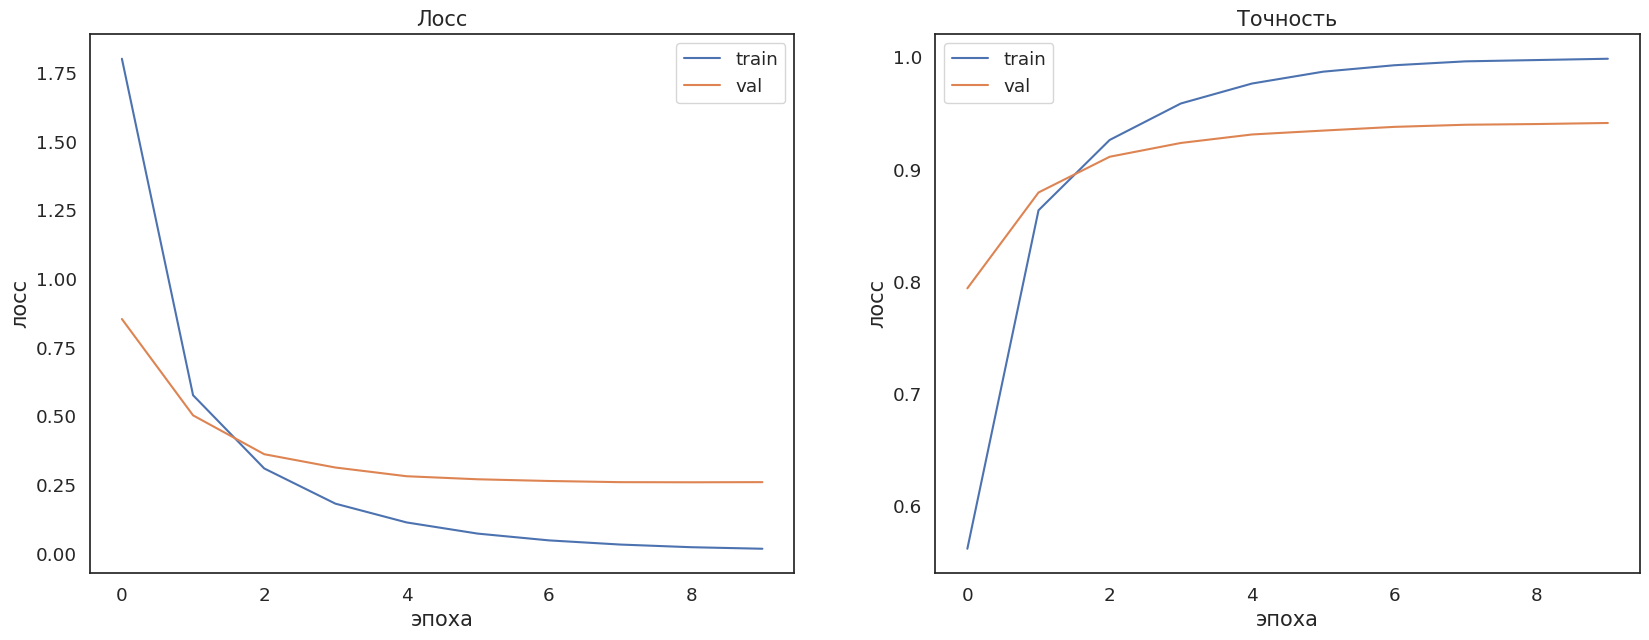

In [79]:
name = 'None'
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10, schedulers=None, names=None
)
results[name] = history

In [80]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [81]:
df_results.to_csv('feature_extraction_all_.csv', index=False)

#### 2.1.3.2. Learning Rate Scheduler = 'Multistep'

Epoch 10 of 10 took 115.769s
  training loss (in-iteration): 	0.434287
  validation loss (in-iteration): 	0.536195
  training accuracy: 			90.13 %
  validation accuracy: 			87.25 %


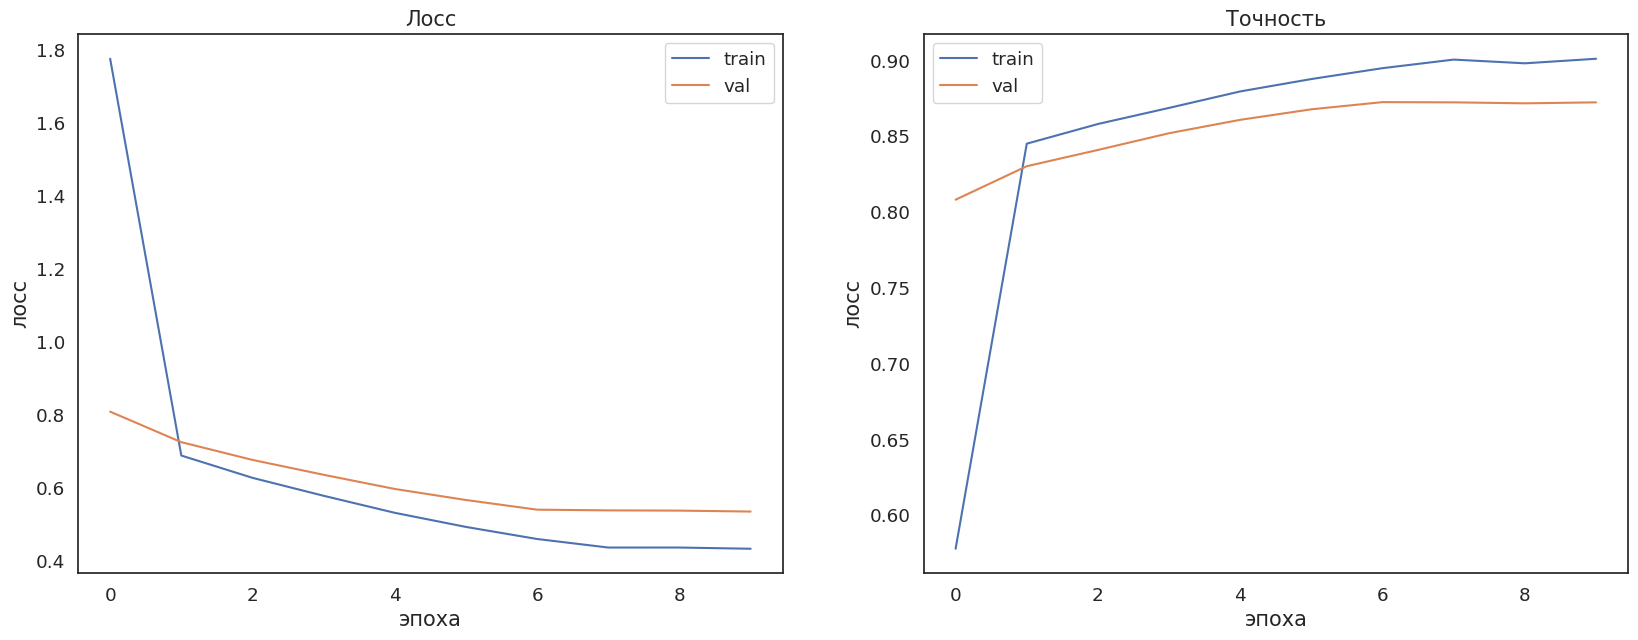

In [83]:
name = 'Multistep'
names = ['Multistep']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs, schedulers, names
)
results[name] = history

In [84]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

Начиная с 7 эпохи - переобучение. Применение шедулера не привело к росту качества

In [85]:
df_results.to_csv('feature_extraction_all_1.csv', index=False)

#### 2.1.3.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau', вариант 1

Epoch 10 of 10 took 115.436s
  training loss (in-iteration): 	0.018389
  validation loss (in-iteration): 	0.261796
  training accuracy: 			99.87 %
  validation accuracy: 			93.97 %


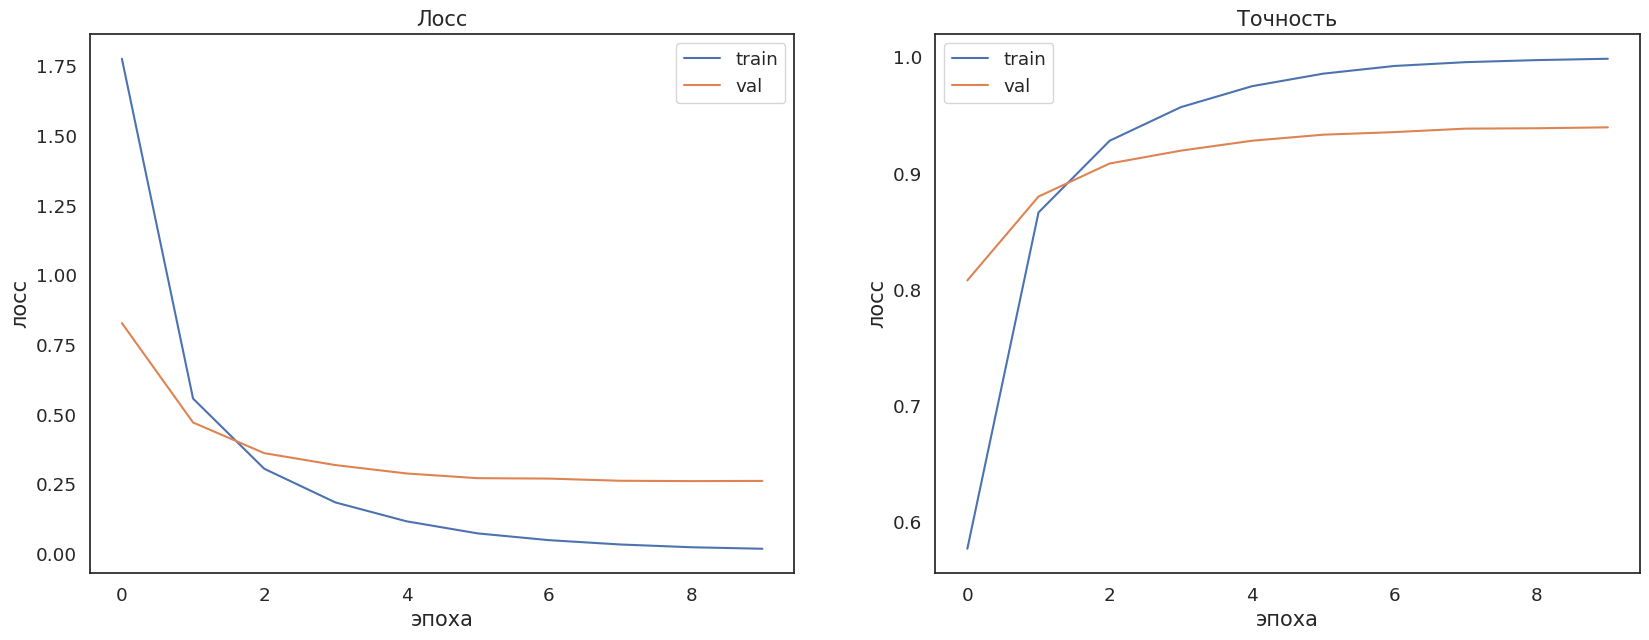

In [87]:
name = 'Combo1'
names = ['MultiStep', 'ReduceLROnPlateau']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs, schedulers, names
)
results[name] = history

In [88]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [89]:
df_results.to_csv('fine_tuning.csv', index=False)

#### 2.1.3.4. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau', вариант 2 

Epoch 10 of 10 took 119.808s
  training loss (in-iteration): 	0.020082
  validation loss (in-iteration): 	0.251982
  training accuracy: 			99.84 %
  validation accuracy: 			94.54 %


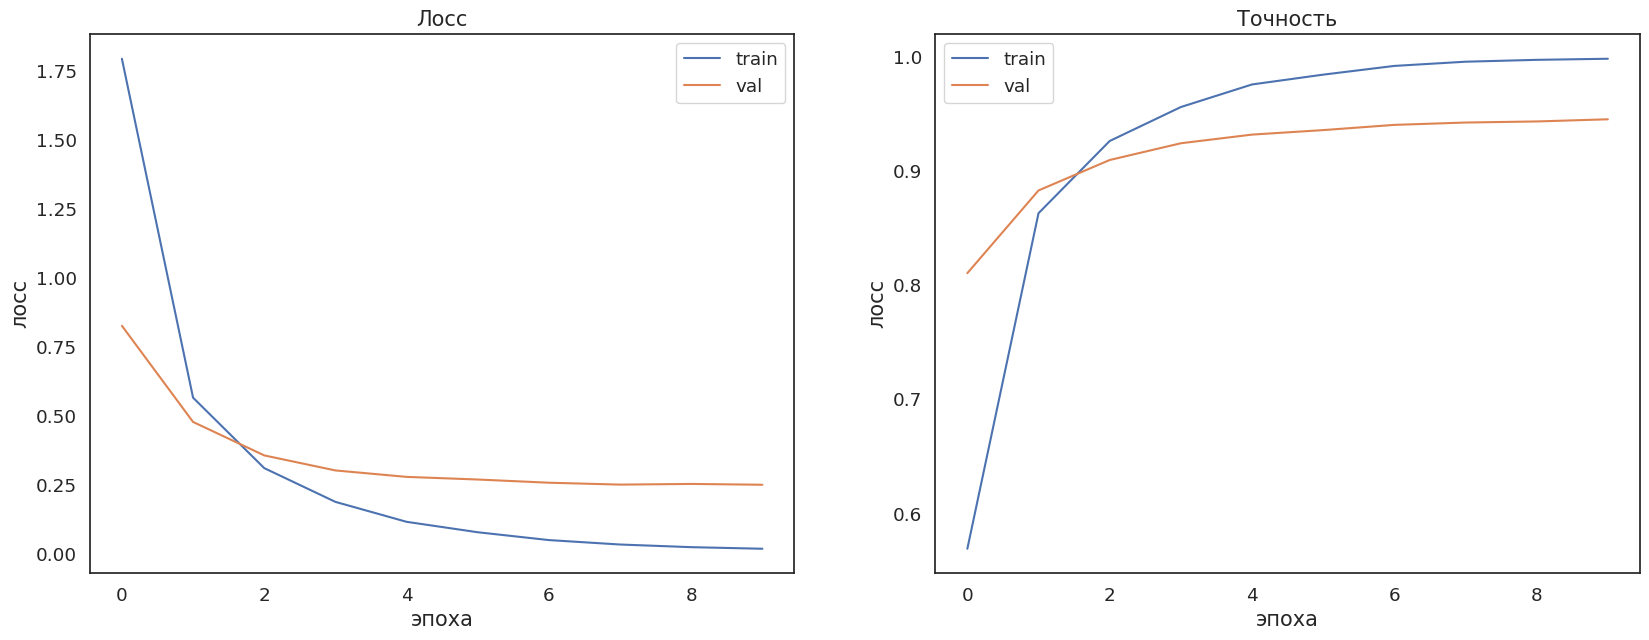

In [91]:
name = 'Combo2'
names = ['MultiStep']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs, schedulers, names
)
results[name] = history

In [92]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [93]:
df_results.to_csv('fine_tuning_combo1.csv', index=False)

Epoch 7 of 7 took 115.070s
  training loss (in-iteration): 	0.005110
  validation loss (in-iteration): 	0.256650
  training accuracy: 			99.99 %
  validation accuracy: 			94.62 %


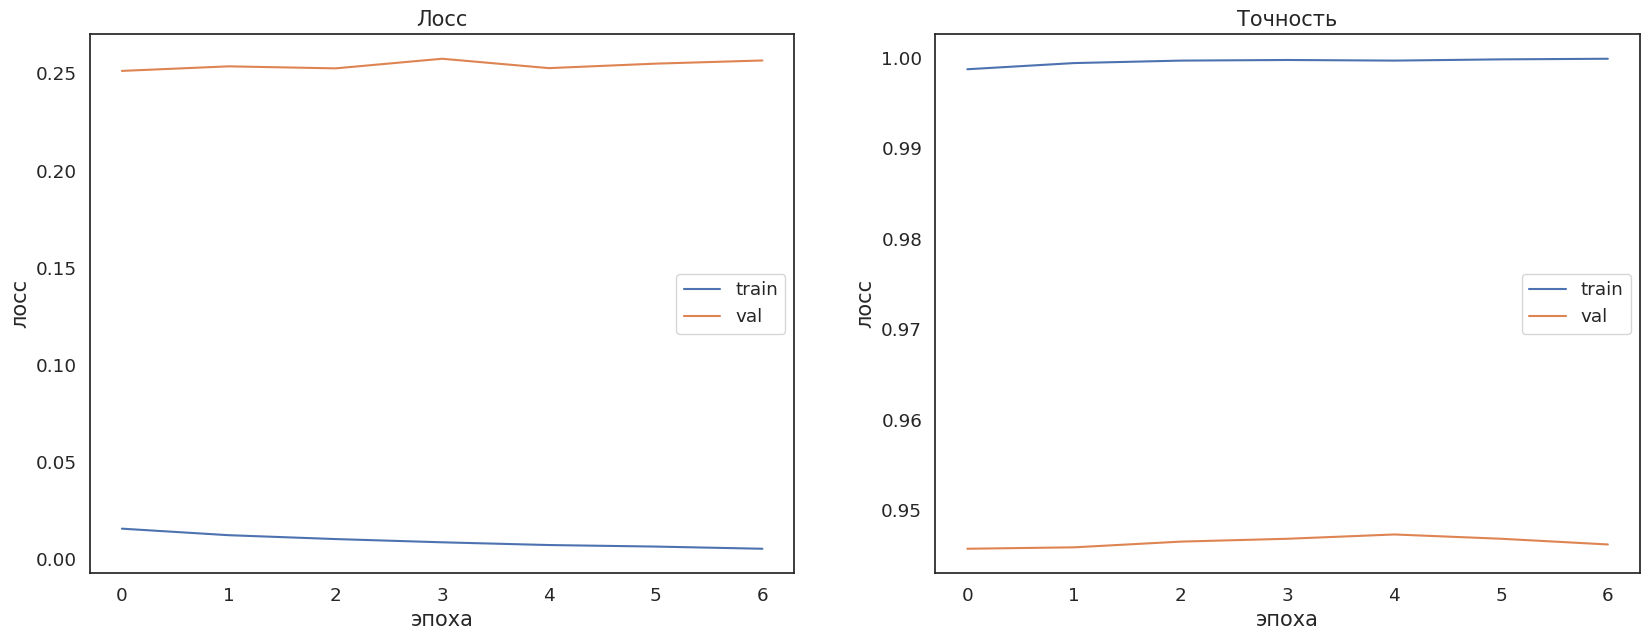

In [94]:
names = ['ReduceLROnPlateau']

optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    7, schedulers, names
)
results[name] = history

In [96]:
for i in range(7):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], 0.01, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [97]:
df_results.to_csv('fine_tuning_combo1_.csv', index=False)

## 2.3. Предположительно "Хорошая" аугментация

In [135]:
# Подготовка датасетов с предположительно хорошей аугментацией
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_good,val_augmentations_good)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


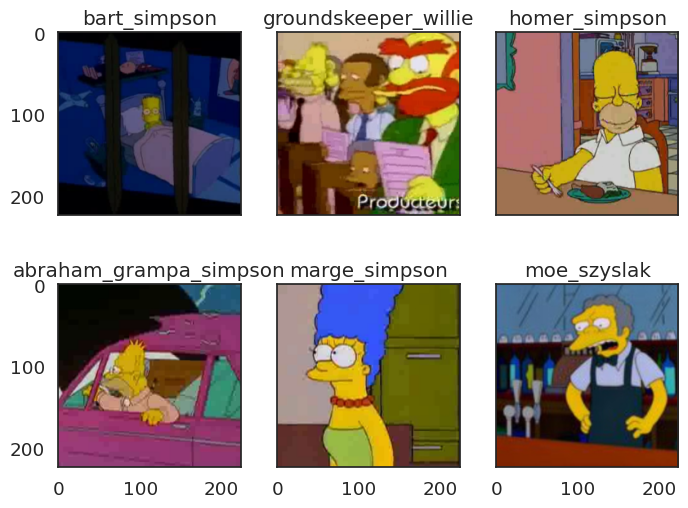

In [99]:
show_images(val_dataset)

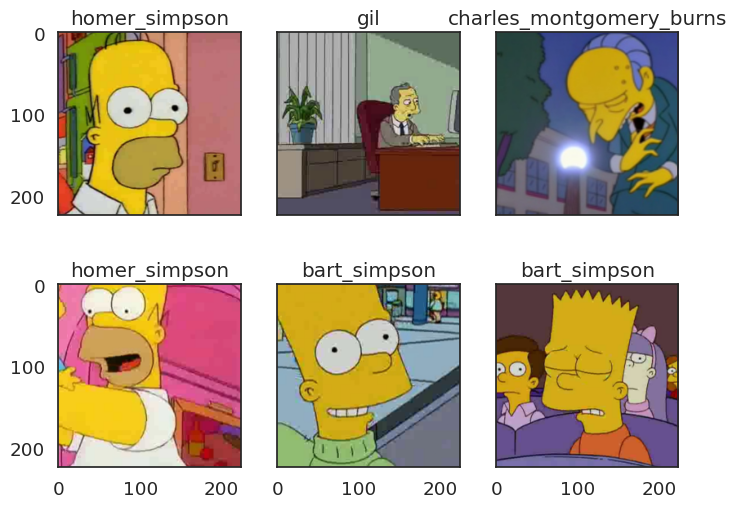

In [100]:
show_images(train_dataset)

Вывод:

In [136]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### 2.3.1. Обучение с нуля

Epoch 10 of 10 took 120.205s
  training loss (in-iteration): 	0.167757
  validation loss (in-iteration): 	0.661863
  training accuracy: 			95.32 %
  validation accuracy: 			83.18 %


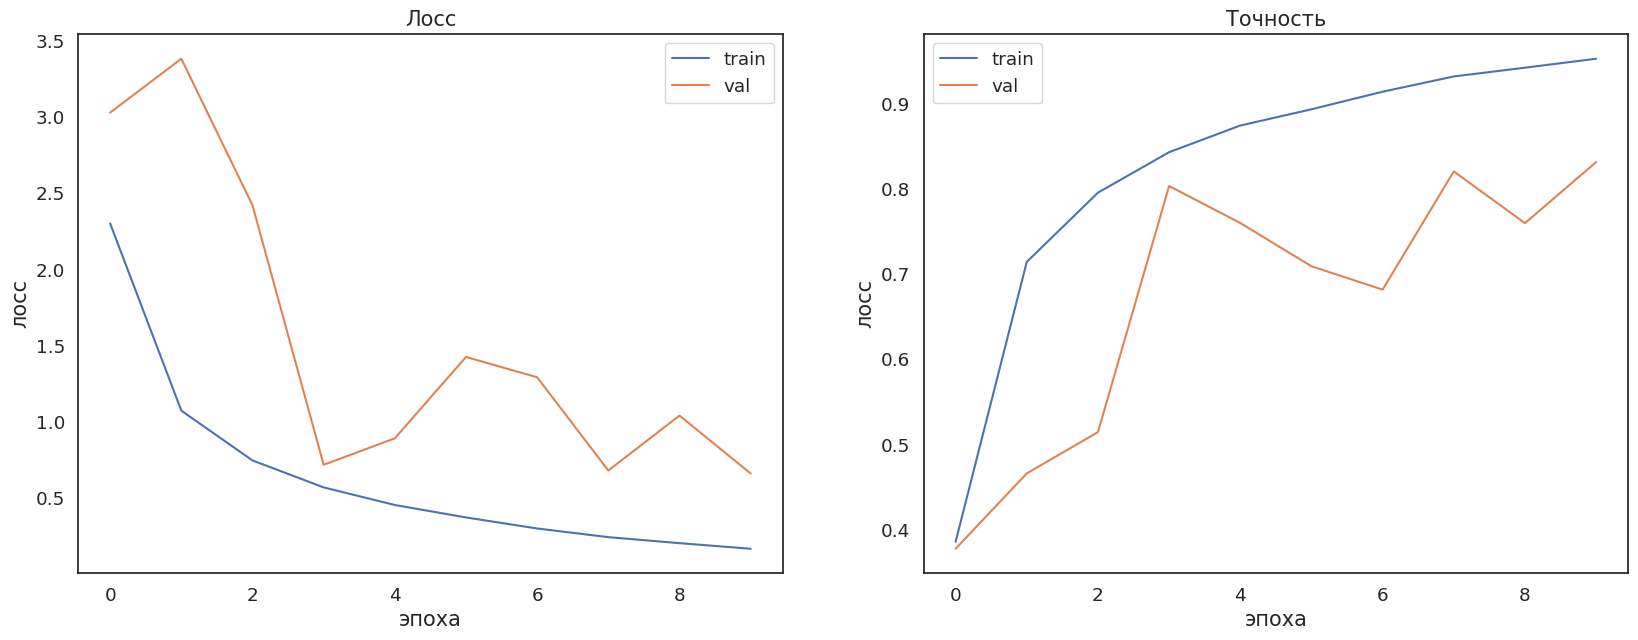

In [110]:
criterion = nn.CrossEntropyLoss()
name='None'
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      10, None, None
  )
results['None'] = history

In [107]:
results[name]

defaultdict(<function __main__.train.<locals>.<lambda>()>,
            {'loss': defaultdict(list,
                         {'train': [0.015455377012629501,
                           0.012094785018079797,
                           0.010101240245202418,
                           0.008431131198624044,
                           0.007021716974805797,
                           0.006232198161036427,
                           0.005110420697413418],
                          'val': [0.2512846494498051,
                           0.2536298463290388,
                           0.25259057700521115,
                           0.25754274569470625,
                           0.25271478724299057,
                           0.25502475979502753,
                           0.2566498100447158]}),
             'acc': defaultdict(list,
                         {'train': [0.9987036026200873,
                           0.9993859170305677,
                           0.9996588427947598,
                  

In [108]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['С нуля','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


В целом при использовании "хорошей" аугментации модель показала результаты примерно на 6% лучше,, чем при использовании базовых (лекционных) аугментаций. При этом accuracy>80% была достигнута уже на 3 эпохе обучения модели

In [111]:
df_results.to_csv('good.csv', index=False)

### 2.3.2. Feature Extraction

Epoch 10 of 10 took 103.559s
  training loss (in-iteration): 	0.699748
  validation loss (in-iteration): 	1.017205
  training accuracy: 			79.96 %
  validation accuracy: 			72.25 %


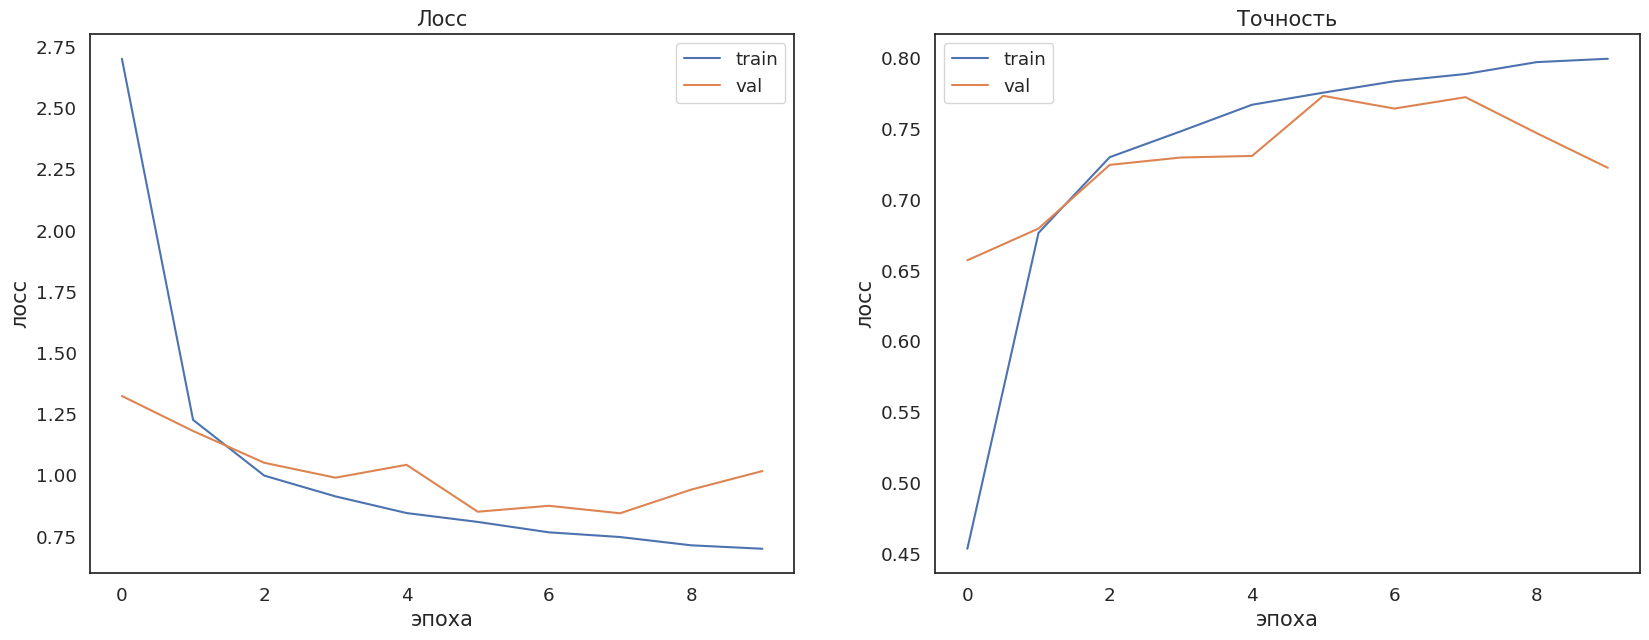

In [115]:
# возьмём предобученную сеть
name = 'None'
fe_model = torchvision.models.resnet18(pretrained=True)
# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [116]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['features_extraction','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [117]:
df_results.to_csv('features_extraction_good.csv', index=False)

### 2.3.3. Fine tuning

Epoch 10 of 10 took 117.494s
  training loss (in-iteration): 	0.033570
  validation loss (in-iteration): 	0.215919
  training accuracy: 			99.54 %
  validation accuracy: 			95.31 %


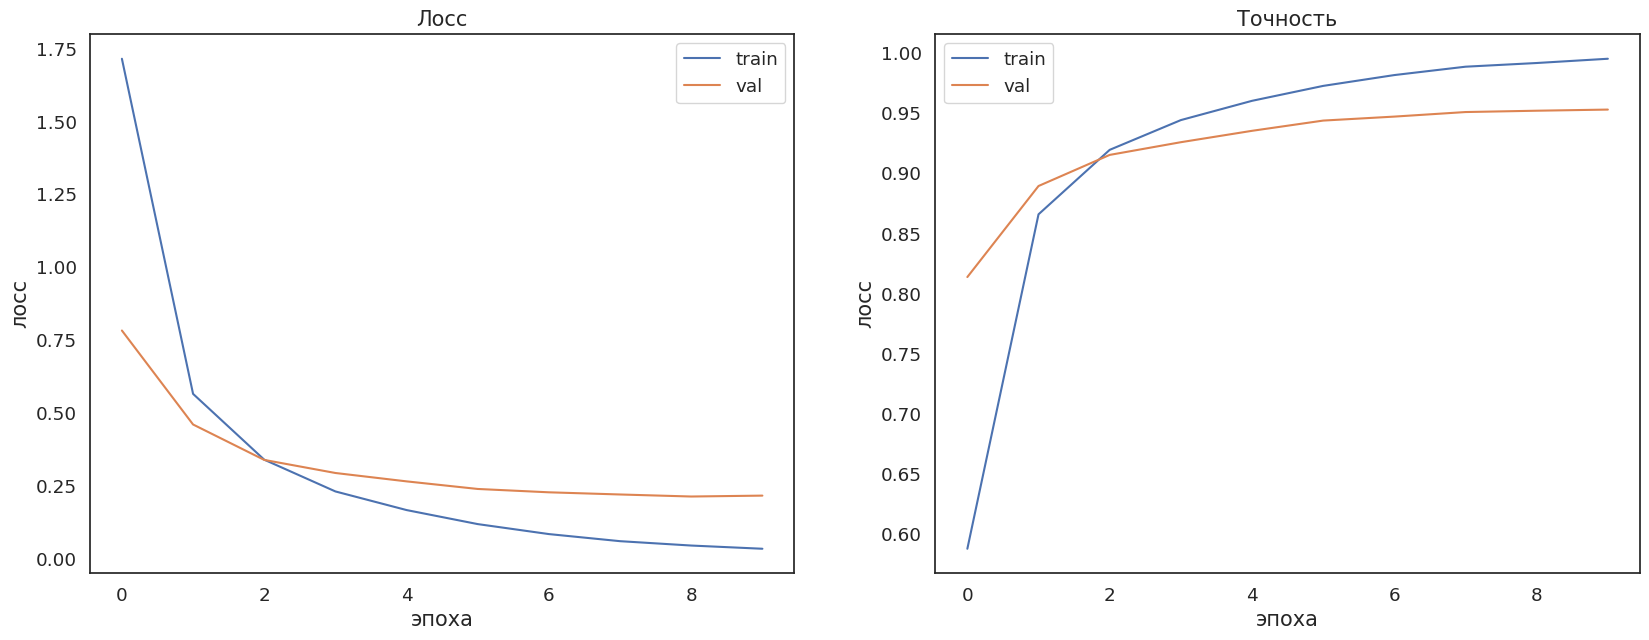

In [119]:
name='None'
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    10, None, None
)
results[name] = history

In [120]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [121]:
df_results.to_csv('fine_tuning_good.csv', index=False)

ПРи использовании "хорошей" аугментации качество модели выше примерно но 1,5% по сравнению с базовой

## 2.4. Предположительно "Плохая" аугментация

In [15]:
# Подготовка датасетов с предположительно плохой аугментацией
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_bad,val_augmentations_bad)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


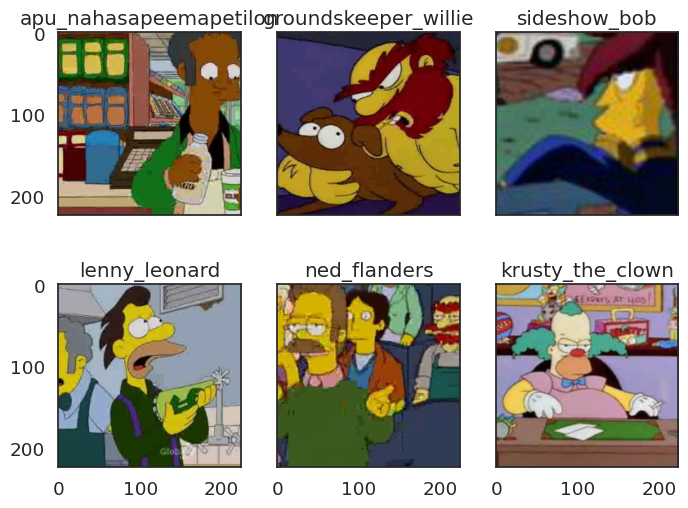

In [18]:
show_images(val_dataset)

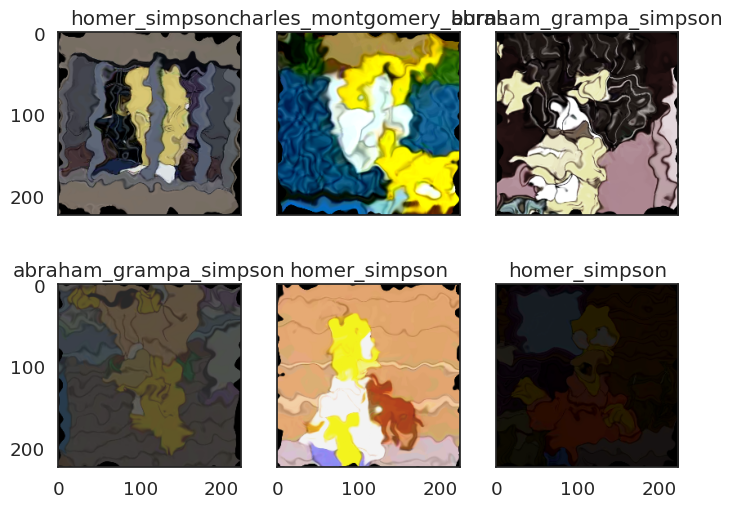

In [139]:
show_images(train_dataset)

In [17]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### 2.4.1. Обучение с нуля

Epoch 10 of 10 took 521.951s
  training loss (in-iteration): 	1.144242
  validation loss (in-iteration): 	1.389048
  training accuracy: 			68.20 %
  validation accuracy: 			63.67 %


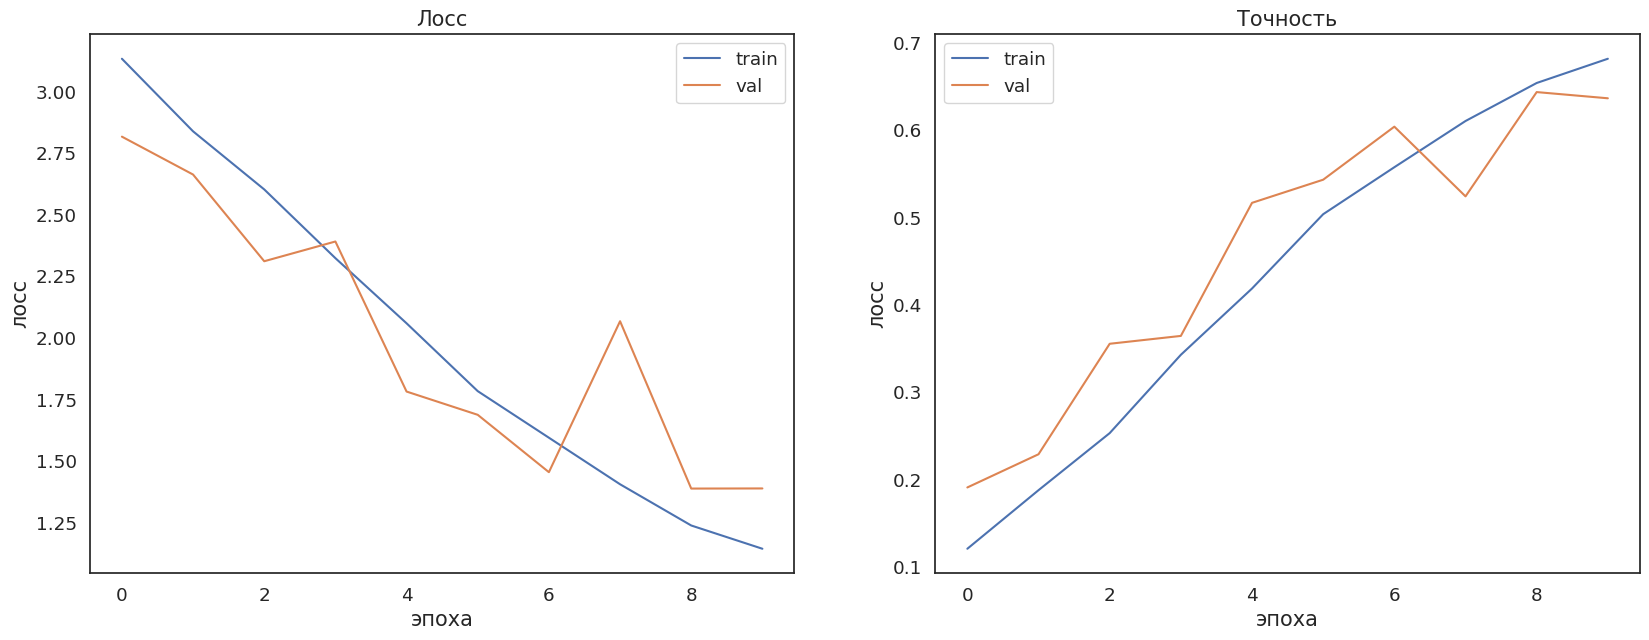

In [142]:
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None
  )
results['None'] = history

In [143]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['С нуля','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


### 2.4.2. Feature Extraction

In [19]:
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s] 


Epoch 10 of 10 took 542.529s
  training loss (in-iteration): 	3.842851
  validation loss (in-iteration): 	4.226256
  training accuracy: 			23.69 %
  validation accuracy: 			27.10 %


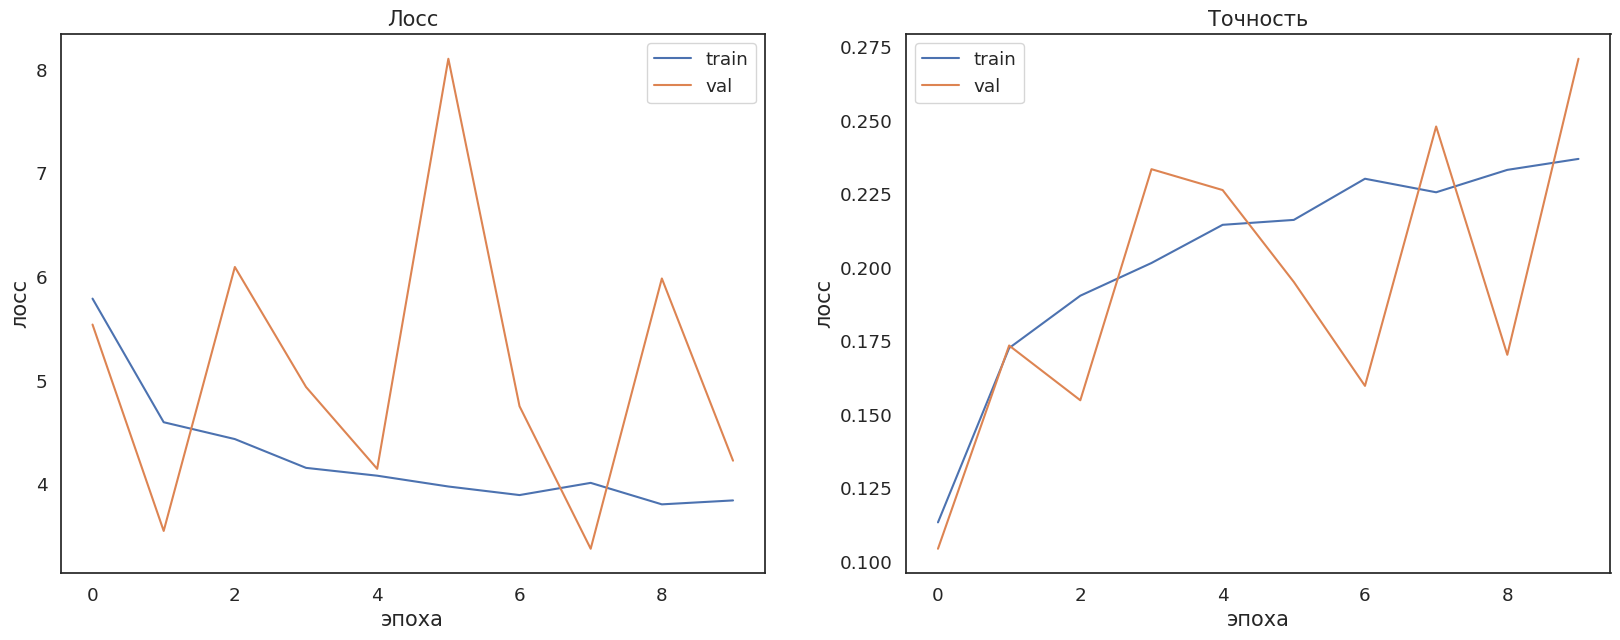

NameError: name 'results' is not defined

In [20]:

name = 'None'

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )


In [21]:
results=dict()
results[name] = history

In [22]:
df_results = pd.DataFrame(columns=['model','augmentation', 'sheduler','time', 'lr', 'epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

In [23]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['features_extraction','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


Вывод: при использовании неудачных вариантов аугментации качество модели серьезно ухудшилось (27,10% против 76,22% На тестовых данных при использовании Feature extraction)

### 2.4.3. Fine tuning

Epoch 10 of 10 took 650.780s
  training loss (in-iteration): 	0.514465
  validation loss (in-iteration): 	0.564440
  training accuracy: 			85.59 %
  validation accuracy: 			84.83 %


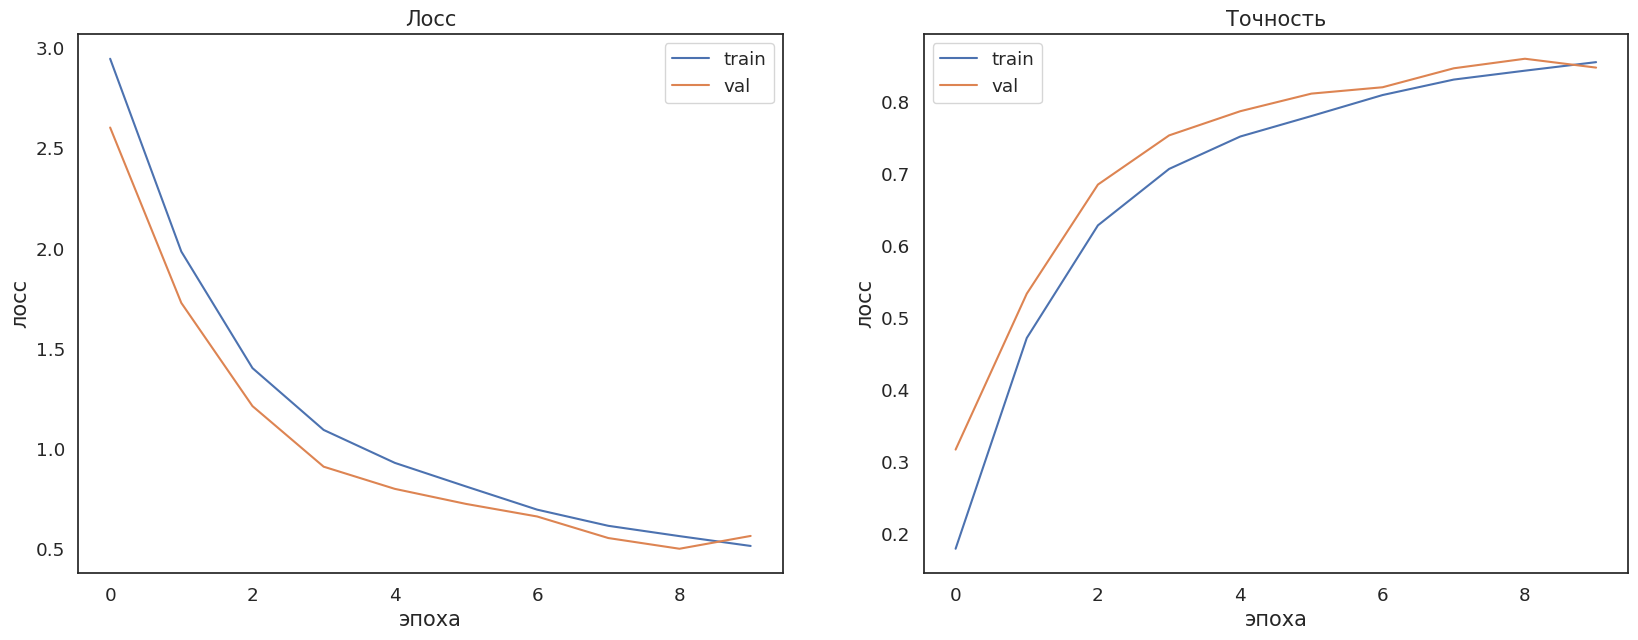

In [27]:
name='None'
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    10, None, None
)

In [28]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [29]:
df_results

model augmentation sheduler        time   lr  epoch  \
0   features_extraction          bad     None  668.608064  0.1      0   
1   features_extraction          bad     None  534.527773  0.1      1   
2   features_extraction          bad     None  531.552065  0.1      2   
3   features_extraction          bad     None  531.983593  0.1      3   
4   features_extraction          bad     None  534.788892  0.1      4   
5   features_extraction          bad     None  534.951064  0.1      5   
6   features_extraction          bad     None  532.969284  0.1      6   
7   features_extraction          bad     None  522.467257  0.1      7   
8   features_extraction          bad     None  540.391397  0.1      8   
9   features_extraction          bad     None  542.528867  0.1      9   
10          fine_tuning          bad     None  562.794008  0.1      0   
11          fine_tuning          bad     None  553.330712  0.1      1   
12          fine_tuning          bad     None  563.327345  0.1      2   
13          fine_tuning          bad     None  560.009708  0.1      3   
14          fine_tuning          bad     None  556.181848  0.1      4   
15          fine_tuning          bad     None  543.317246  0.1      5   
16          fine_tuning          bad     None  545.118440  0.1      6   
17          fine_tuning          bad     None  551.604755  0.1      7   
18          fine_tuning          bad     None  617.406203  0.1      8   
19          fine_tuning          bad     None  650.779902  0.1      9   

    train_loss  train_accuracy  val_loss  val_accuracy  
0     5.789891        0.113294  5.539564      0.104324  
1     4.597209        0.172591  3.548468      0.173453  
2     4.434634        0.190393  6.094919      0.154830  
3     4.156941        0.201521  4.937274      0.233428  
4     4.081396        0.214505  4.147452      0.226326  
5     3.977097        0.216177  8.104036      0.195076  
6     3.894460        0.230178  4.751708      0.159722  
7     4.012118        0.225572  3.376545      0.247948  
8     3.804886        0.233194  5.984124      0.170297  
9     3.842851        0.236923  4.226256      0.270991  
10    5.789891        0.113294  5.539564      0.104324  
11    4.597209        0.172591  3.548468      0.173453  
12    4.434634        0.190393  6.094919      0.154830  
13    4.156941        0.201521  4.937274      0.233428  
14    4.081396        0.214505  4.147452      0.226326  
15    3.977097        0.216177  8.104036      0.195076  
16    3.894460        0.230178  4.751708      0.159722  
17    4.012118        0.225572  3.376545      0.247948  
18    3.804886        0.233194  5.984124      0.170297  
19    3.842851        0.236923  4.226256      0.270991

In [35]:
df_results.to_csv('all_results_.csv', index=False)

Вывод: при использовании тонкой настройки и различных вариантов аугментаций разница в качестве не столь великк, как при feature_extraction (accuracy на тесте при базовой аугментации 94,62%, при хорошей аугментации - 95,31%, при плохой - 84,83% ( почти на 10% меньше)